# NEM Review report charts
## Chart code and data
### Prepare Python environment

In [27]:
# Libraries
import datetime as dt, matplotlib.pyplot as plt, matplotlib as mpl
import numpy as np, os, pandas as pd, seaborn as sns
from sqlalchemy import create_engine, text
from scripts.functions import python_setup, get_mms_data, fix_area_chart_data

# Set up Python
working_dir, charts_dir, data_dir = python_setup()

### Past and projected capacity, 2008-09 to 2049-50

In [28]:
# Generation capacity mix
gen_capacity_mix = pd.read_csv(
    os.path.join(data_dir, "isp_capacity_mix.csv"),
    converters={
        "Year": lambda x: pd.to_datetime(f"01-01-20{x[-2:]}").year},
    index_col=[0]).fillna(0)

# Generation capacity key
gen_capacity_key = pd.read_csv(
    os.path.join(data_dir, "isp_capacity_key.csv"),
    index_col=0)[["Weather dependence", "Dispatchability", "Visibility and scheduling", "Energy limits", "System services"]]

coal_data = pd.read_csv(
    os.path.join(data_dir, "coal.tsv"),
    sep="\t")

# Nature of marginal prices
marginal_prices = pd.DataFrame(
    columns=["Constant marginal cost", "Opportunity cost of fuel", "Opportunity cost of electricity", "Zero marginal cost"],
    index=gen_capacity_mix.index)
# Calculate
marginal_prices["Constant marginal cost"] = (
    gen_capacity_mix.loc[:, "Brown coal"] +
    gen_capacity_mix.loc[:, "Biomass"] +
    gen_capacity_mix.index.map(lambda i: gen_capacity_mix.loc[i, ["Mid-merit gas", "Flexible gas"]].sum() if i <= 2015 else 0))
marginal_prices["Opportunity cost of fuel"] = (
    gen_capacity_mix.loc[:, "Black coal"] +
    gen_capacity_mix.index.map(lambda i: gen_capacity_mix.loc[i, ["Mid-merit gas", "Flexible gas"]].sum() if i > 2015 else 0))
marginal_prices["Opportunity cost of electricity"] = (
    gen_capacity_mix.loc[:, "Hydro"] +
    gen_capacity_mix.loc[:, "Utility storage"])
marginal_prices["Zero marginal cost"] = (
    gen_capacity_mix.loc[:, "Coordinated CER storage"] +
    gen_capacity_mix.loc[:, "Passive CER storage"] +
    gen_capacity_mix.loc[:, "Offshore wind"] +
    gen_capacity_mix.loc[:, "Onshore wind"] +
    gen_capacity_mix.loc[:, "Utility solar"] +
    gen_capacity_mix.loc[:, "Rooftop solar and other distributed solar"])
# Differentiate black coal stations
for y in marginal_prices.index:    
    mine_to_mouth = coal_data[
        (coal_data["Expected retirement"] >= y) &
        coal_data["Mine-to-mouth"]]["Maximum capacity (MW)"].sum()
    marginal_prices.at[y, "Constant marginal cost"] = marginal_prices.at[y, "Constant marginal cost"] + mine_to_mouth
    marginal_prices.at[y, "Opportunity cost of fuel"] = marginal_prices.at[y, "Opportunity cost of fuel"] - mine_to_mouth

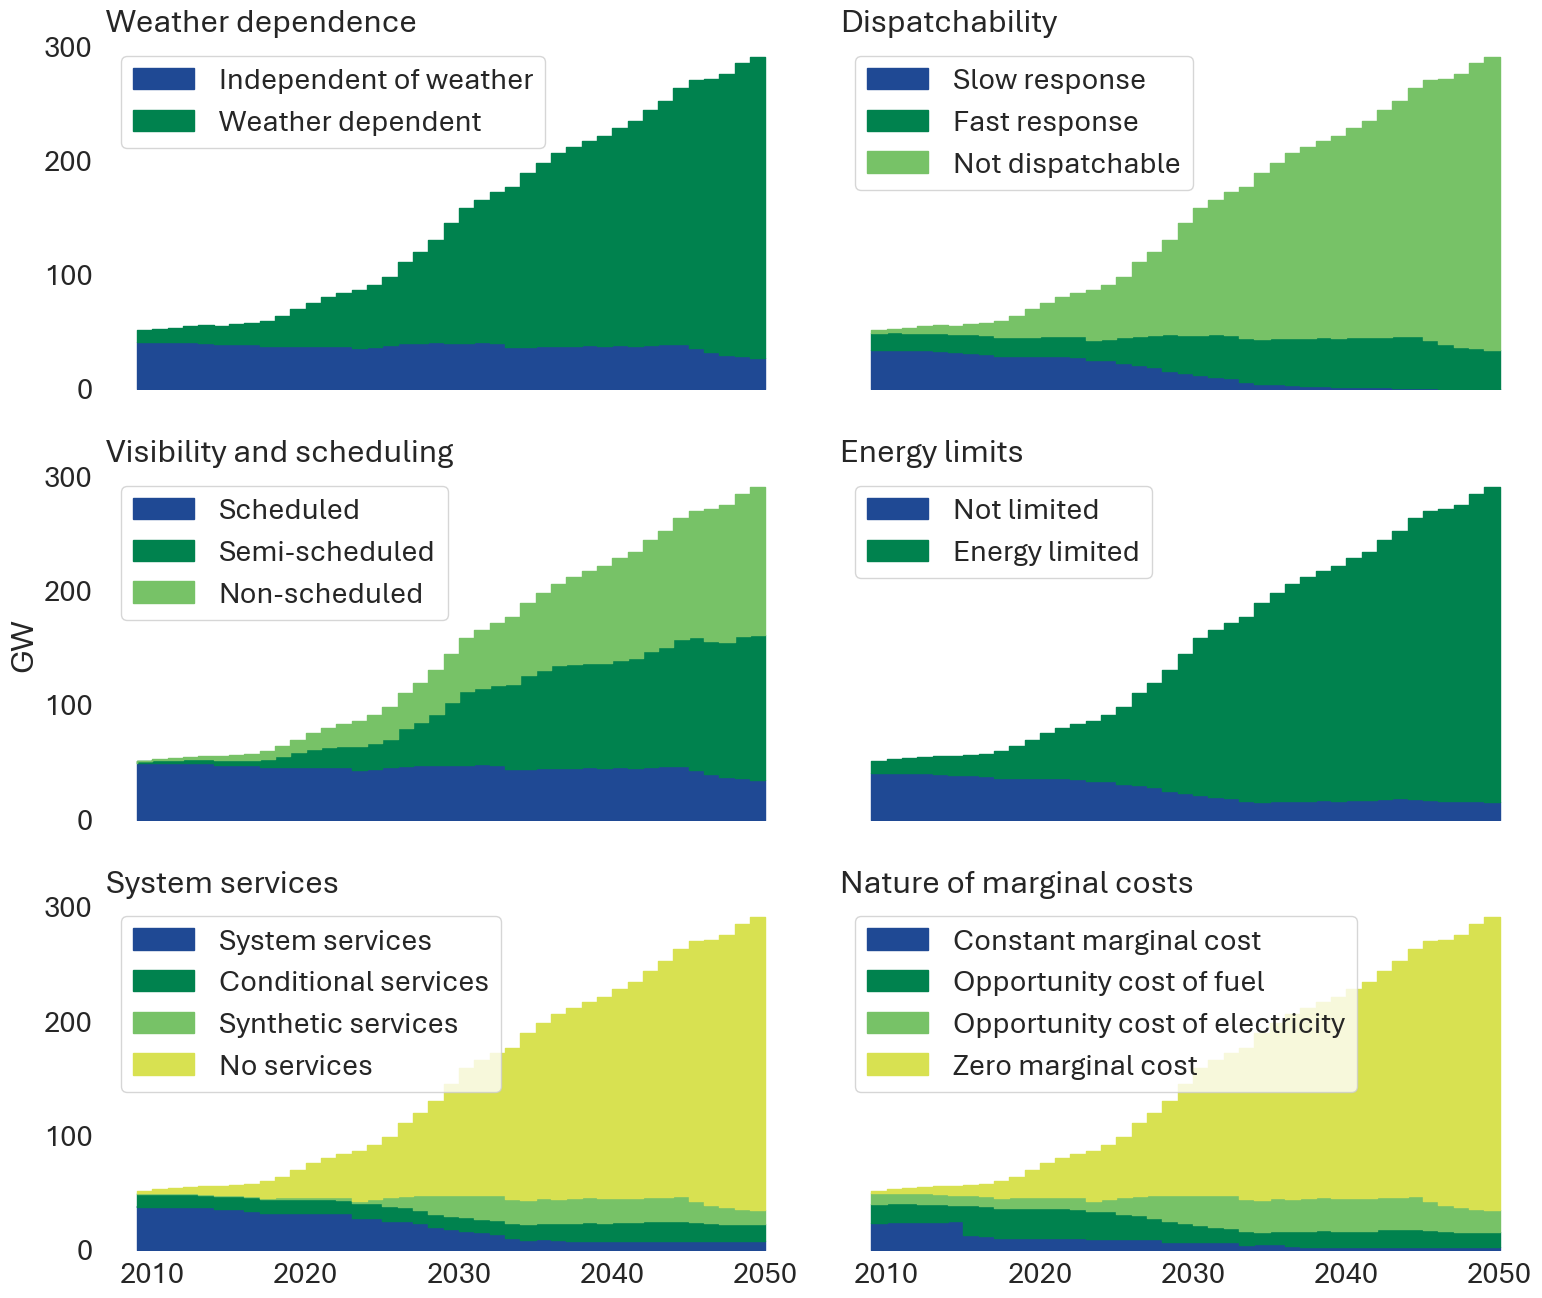

In [29]:
# Plot charts
fig, ax = plt.subplots(
    3, 2,
    figsize=(16, 9 * 1.5),
    tight_layout=True,
    sharey=True,
    sharex=True)
palette = sns.color_palette()[1:]

for i, key in enumerate(gen_capacity_key.columns):
    axis = ax[i // 2, i % 2]
    plot_data = pd.DataFrame(
        columns=gen_capacity_key[key].unique(),
        index=gen_capacity_mix.index)
    for col in plot_data.columns:
        plot_data[col] = gen_capacity_mix[gen_capacity_key[gen_capacity_key[key] == col].index].sum(axis=1)
    if key == "Visibility and scheduling":
        plot_data = plot_data[["Scheduled", "Semi-scheduled", "Non-scheduled"]]
    for i, col in enumerate(plot_data):
        axis.fill_between(
            plot_data.index,
            plot_data.cumsum(axis=1).iloc[:, i],
            (0 if i == 0 else plot_data.cumsum(axis=1).iloc[:, i - 1]),
            color=palette[i],
            label=col,
            step="pre")
    for frame in ["top", "left", "bottom", "right"]:
        axis.spines[frame].set_visible(False)
    axis.set_xlabel(None)
    axis.set_ylabel(("GW" if key == "Visibility and scheduling" else None))
    axis.set_title(key, loc="left")
    axis.yaxis.set_major_formatter(lambda x, p: f"{x/1000:,.0f}")
    axis.legend()
    # Copy data
    if key == "Weather dependence":
        plot_data.to_clipboard()

# Nature of marginal prices
axis = ax[2, 1]
for i, col in enumerate(marginal_prices):
    axis.fill_between(
        marginal_prices.index,
        marginal_prices.cumsum(axis=1).iloc[:, i],
        (0 if i == 0 else marginal_prices.cumsum(axis=1).iloc[:, i - 1]),
        color=palette[i],
        label=col,
        step="pre")
for frame in ["top", "left", "bottom", "right"]:
    axis.spines[frame].set_visible(False)
axis.set_xlabel(None)
axis.set_ylim(0,)
axis.set_title("Nature of marginal costs", loc="left")
axis.legend()
plt.show()

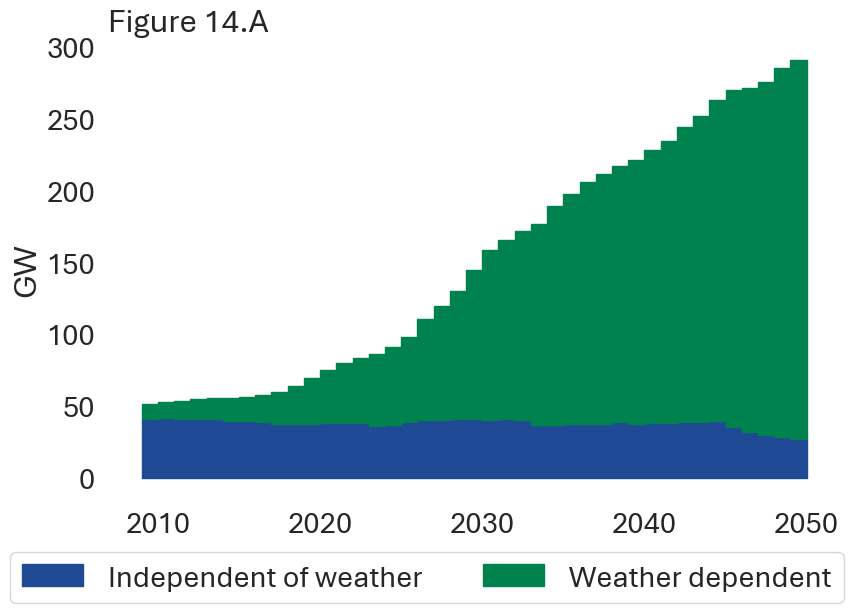

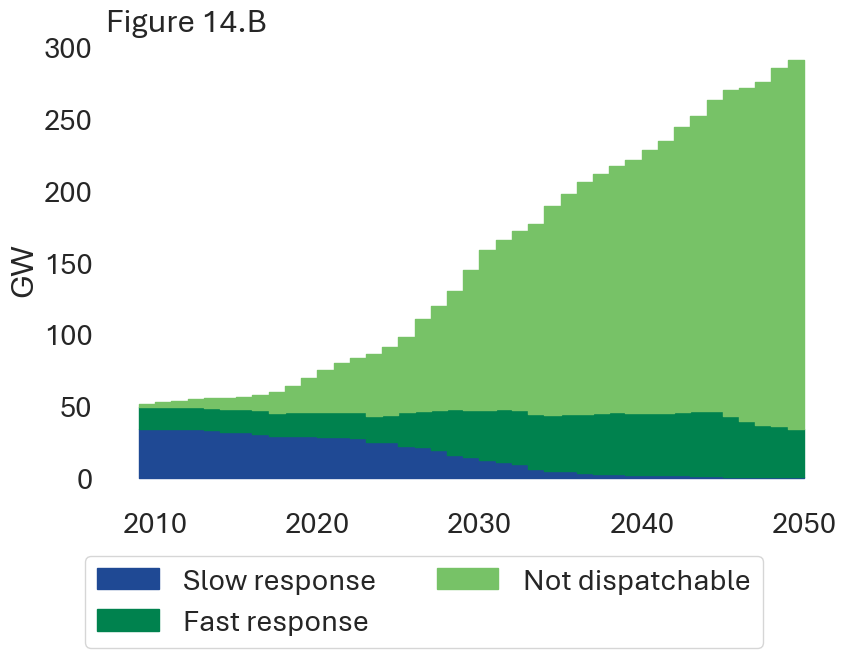

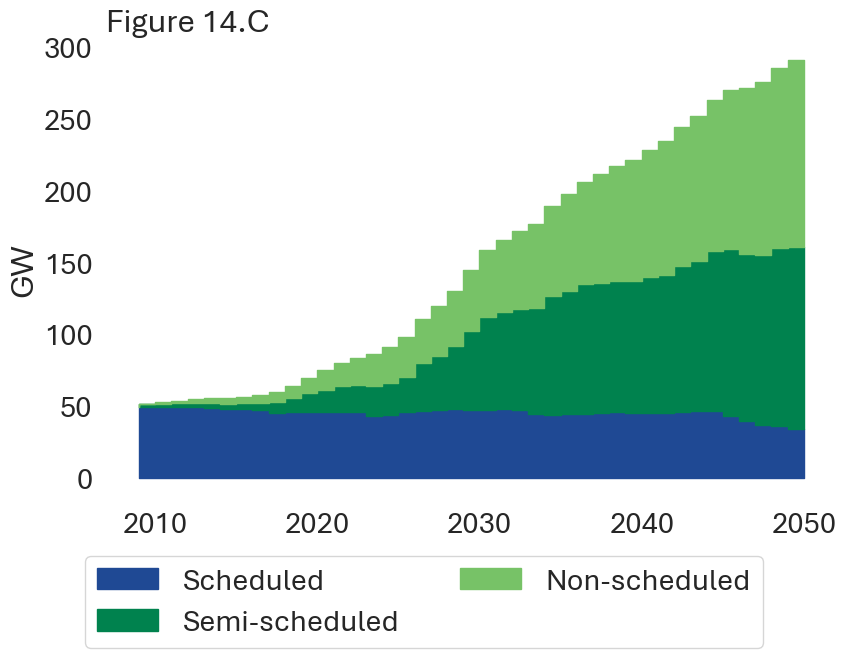

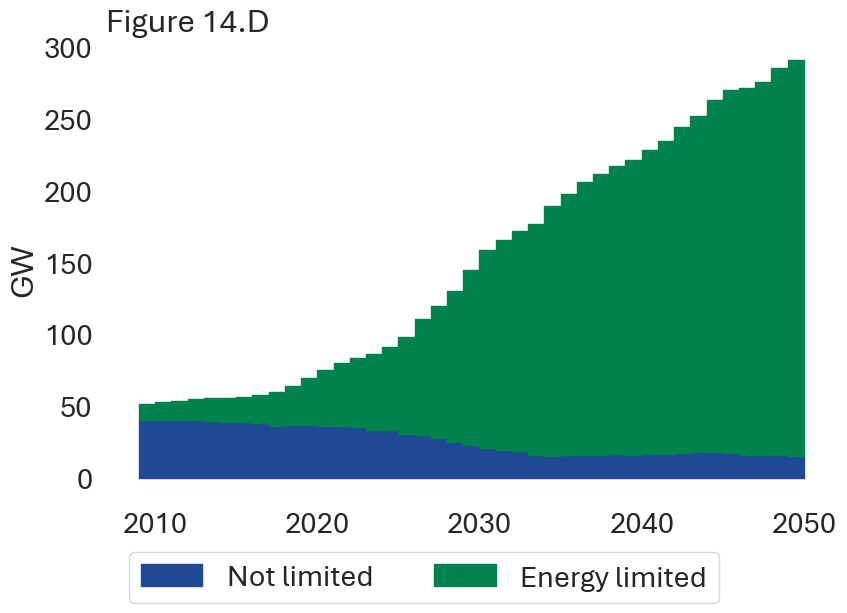

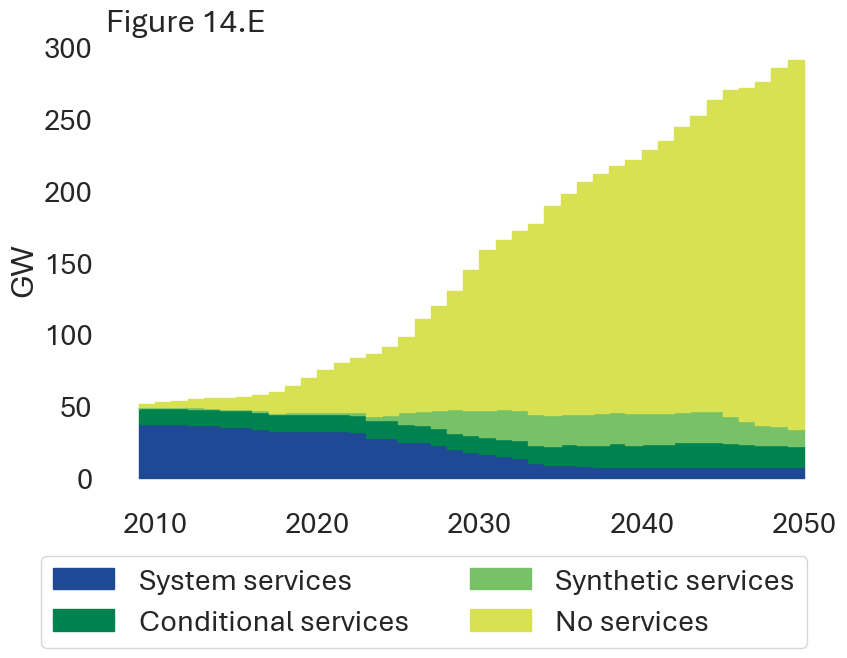

In [30]:
# Plot charts
for j, key in enumerate(gen_capacity_key.columns):
    fig, ax = plt.subplots(
        figsize=(9, 6),
        tight_layout=True)
    plot_data = pd.DataFrame(
        columns=gen_capacity_key[key].unique(),
        index=gen_capacity_mix.index)
    for col in plot_data.columns:
        plot_data[col] = gen_capacity_mix[gen_capacity_key[gen_capacity_key[key] == col].index].sum(axis=1)
    if key == "Visibility and scheduling":
        plot_data = plot_data[["Scheduled", "Semi-scheduled", "Non-scheduled"]]
    for i, col in enumerate(plot_data):
        ax.fill_between(
            plot_data.index,
            plot_data.cumsum(axis=1).iloc[:, i],
            (0 if i == 0 else plot_data.cumsum(axis=1).iloc[:, i - 1]),
            color=palette[i],
            label=col,
            step="pre")
    for frame in ["top", "left", "bottom", "right"]:
        ax.spines[frame].set_visible(False)
    plt.xlabel(None)
    plt.ylabel("GW")
    plt.title(f"Figure 14.{['A', 'B', 'C', 'D', 'E', 'F'][j]}", loc="left")
    ax.yaxis.set_major_formatter(lambda x, p: f"{x/1000:,.0f}")
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, (-0.075 if plot_data.shape[1] < 3 else -0.15)), ncol=2)
    plot_data.to_csv(
        os.path.join(charts_dir, f"chart_data_figure_12{['A', 'B', 'C', 'D', 'E', 'F'][j]}_{key.lower().replace(' ', '_')}.csv")
    )
    plt.show()

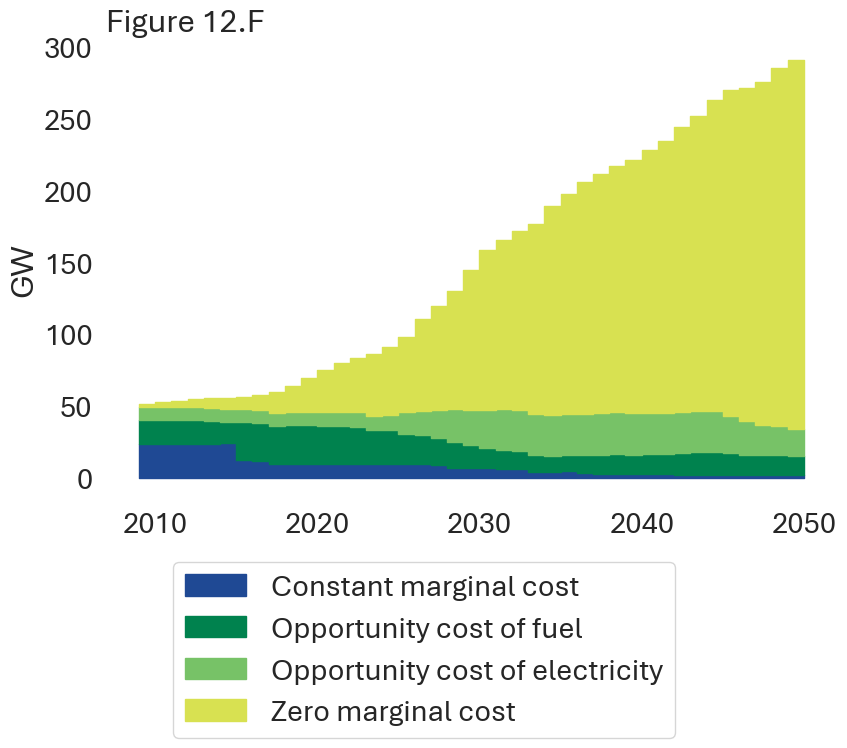

In [31]:
# Nature of marginal prices
fig, ax = plt.subplots(
        figsize=(9, 6),
        tight_layout=True)
for i, col in enumerate(marginal_prices):
    ax.fill_between(
        marginal_prices.index,
        marginal_prices.cumsum(axis=1).iloc[:, i],
        (0 if i == 0 else marginal_prices.cumsum(axis=1).iloc[:, i - 1]),
        color=palette[i],
        label=col,
        step="pre")
for frame in ["top", "left", "bottom", "right"]:
    ax.spines[frame].set_visible(False)
plt.xlabel(None)
plt.ylabel("GW")
plt.title(f"Figure 12.F", loc="left")
ax.yaxis.set_major_formatter(lambda x, p: f"{x/1000:,.0f}")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=1)
marginal_prices.to_csv(
    os.path.join(charts_dir, "chart_data_figure_12E_marginal_prices.csv"))
plt.show()

### $300 cap trade volumes

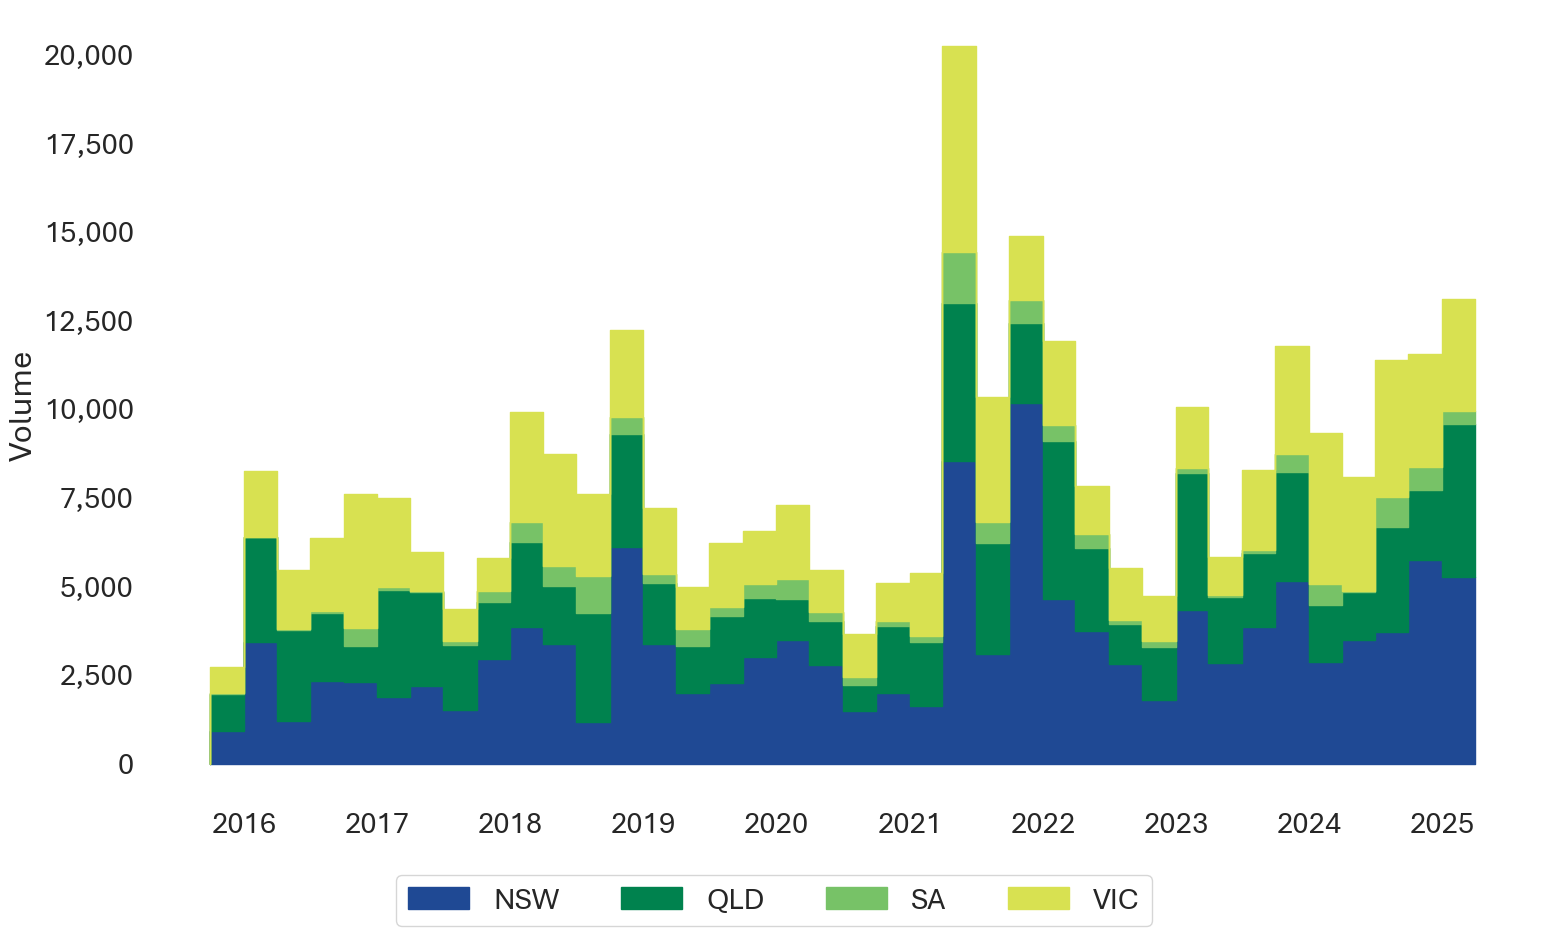

In [32]:
# Load contract data
asx_data = pd.read_csv(    
    os.path.join(data_dir, "asx_cap_volumes_by_qtr.csv"),
    parse_dates=[0]).fillna(0)
# Alter column names
asx_data.columns = [(
    "Time" if "Time" in c else
    c[20:c.index(" $")]
) for c in asx_data.columns]
# Adjust quarter
asx_data["Time"] = asx_data["Time"] - pd.offsets.QuarterBegin() + pd.offsets.MonthEnd()
# Prepare cap contract data
cap_trades = pd.DataFrame(
    columns=["NSW", "QLD", "SA", "VIC"],
    index=asx_data["Time"])
cap_trades.index.name = "Quarter"
# Aggregate by state
for state in cap_trades.columns:
    cap_trades[state] = 0 # Initialise with 0
    for c in asx_data.columns[1:]:        
        if state in c:
            if "Q" in c:                
                cap_trades[state] = cap_trades[state].values + asx_data[c].values
            else:
                cap_trades[state] = cap_trades[state].values + asx_data[c].values * 4
# Cleaned data
cap_trades.to_csv(os.path.join(data_dir, "asx_cap_trade_volumes_qtr.csv"))
cap_trades_yr = cap_trades.resample("YE").sum().iloc[1:-1]
cap_trades_yr.index.name = "Year"
cap_trades_yr.to_csv(os.path.join(data_dir, "asx_cap_trade_volumes_yr.csv"))

# Plot charts
fig, ax = plt.subplots(
    figsize=(16, 9),
    tight_layout=True)
palette = sns.color_palette()[1:]
cap_trades.loc[pd.to_datetime("2015-09-30")] = [0, 0, 0, 0]
cap_trades.sort_index(inplace=True)
for i in range(len(cap_trades.columns)):
    ax.fill_between(
        cap_trades.index,
        cap_trades.cumsum(axis=1)[cap_trades.columns[i]],
        (0 if i == 0 else cap_trades.cumsum(axis=1)[cap_trades.columns[i - 1]]),
        color=f"C{i + 1}",
        label=cap_trades.columns[i],
        step="pre")
for frame in ["top", "left", "bottom", "right"]:
    ax.spines[frame].set_visible(False)
plt.xlabel(None)
plt.ylabel("Volume")
# plt.title("Volume of $300 cap contracts traded per quarter", loc="left", fontsize="large")
ax.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.075), ncol=4)
plt.show()

### The rising prices of $300 cap futures contracts

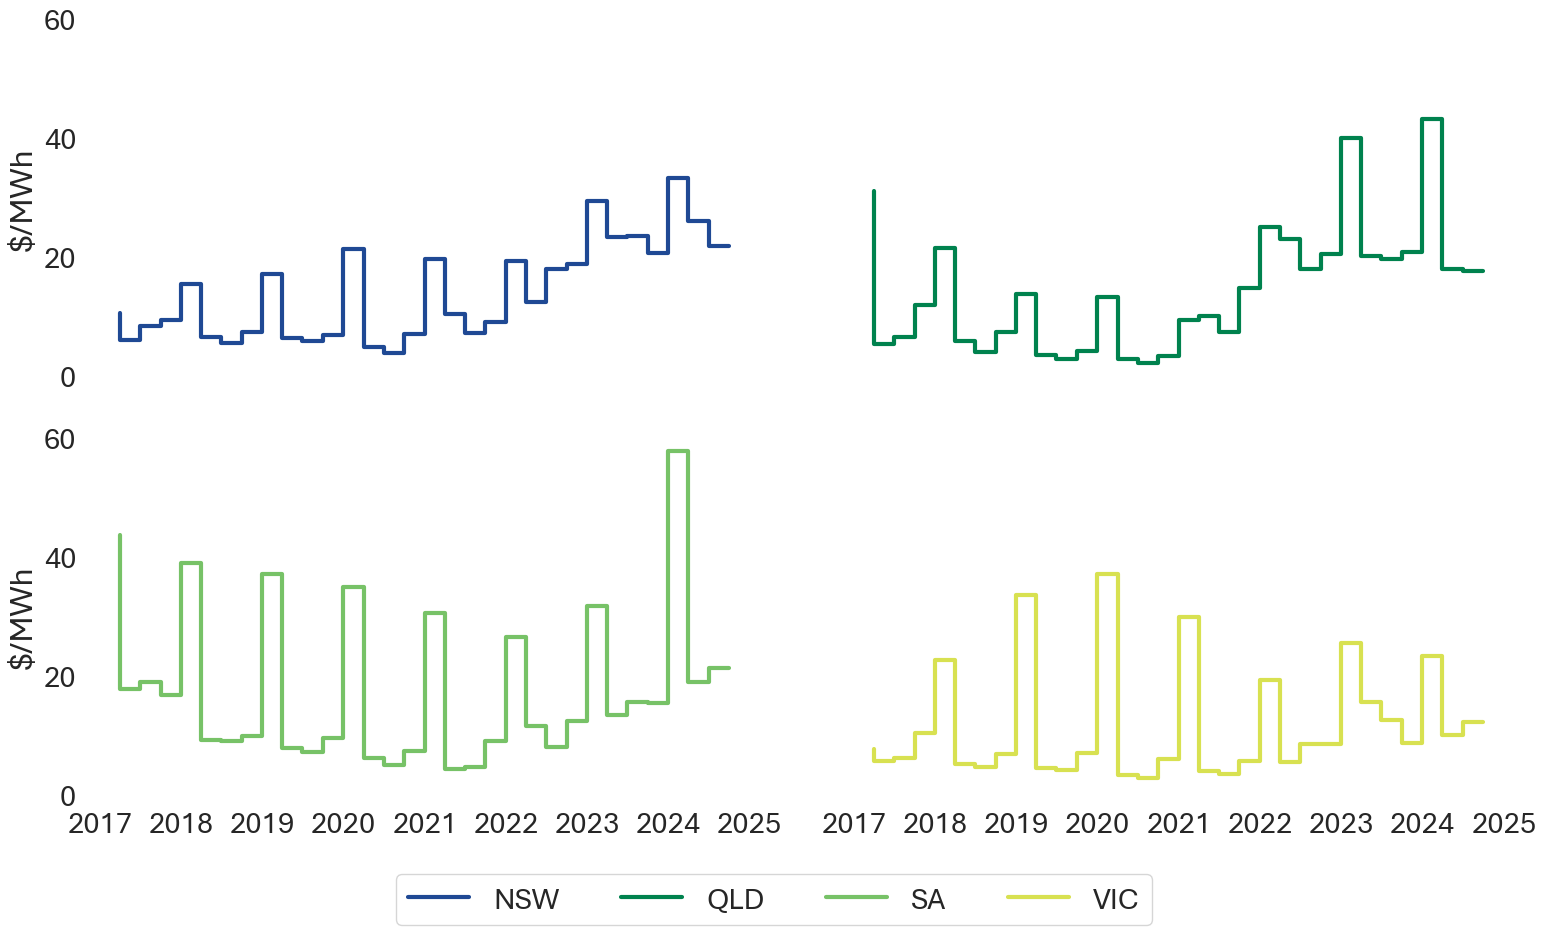

In [33]:
# Load data
cap_data = pd.read_csv(
    os.path.join(data_dir, "cap_prices_and_demand.csv"),
    parse_dates=[0],
    index_col=0)
cap_data.index.name = "Time"
# Structure
cap_data["Quarter"] = cap_data.index.to_period("Q")

# Chart data
chart_data = pd.DataFrame(
    columns=["NSW", "QLD", "SA", "VIC"],
    index=pd.date_range("2017Q1", "2024Q4", freq="QE"))
chart_data.index.name = "Quarter"
# Iterate through caps and populate chart data
for quarter in chart_data.index:
    quarter_string = f"{quarter:%Y} Q{quarter.month // 3}"
    for region in chart_data.columns:
        value, volume = [0, 0]
        # Quarter caps
        qtr_contracts = cap_data[[
            c for c in cap_data.columns if
            (quarter_string in c) &
            (region in c)]]
        if qtr_contracts.shape[1] == 2:
            traded_value = (qtr_contracts.iloc[:, 0] * qtr_contracts.iloc[:, 1]).sum()        
            traded_volume = qtr_contracts[[c for c in qtr_contracts.columns if "Volume" in c]].iloc[:, 0].sum()
            value = value + traded_value
            volume = volume + traded_volume
        # Calendar year
        cal_contracts = cap_data[[
            c for c in cap_data.columns if 
            ("Calendar" in c) *
            (str(quarter.year) in c) &
            (region in c)]]
        if cal_contracts.shape[1] == 2:
            traded_value = (cal_contracts.iloc[:, 0] * cal_contracts.iloc[:, 1]).sum() / 4
            traded_volume = cal_contracts[[c for c in cal_contracts.columns if "Volume" in c]].iloc[:, 0].sum() / 4
            value = value + traded_value
            volume = volume + traded_volume            
        # Financial year
        fin_year = quarter.year + (0 if quarter.month < 7 else 1)        
        fin_contracts = cap_data[[
            c for c in cap_data.columns if 
            ("Calendar" in c) *
            (str(fin_year) in c) &
            (region in c)]]
        if fin_contracts.shape[1] == 2:
            traded_value = (fin_contracts.iloc[:, 0] * fin_contracts.iloc[:, 1]).sum() / 4
            traded_volume = fin_contracts[[c for c in fin_contracts.columns if "Volume" in c]].iloc[:, 0].sum() / 4
            value = value + traded_value
            volume = volume + traded_volume
        chart_data.at[quarter, region] = value / volume

# Plot charts
fig, ax = plt.subplots(
    2, 2,
    figsize=(16, 9),
    tight_layout=True,
    sharex=True,
    sharey=True)
# chart_data.loc[pd.to_datetime("2016-12-31")] = [0, 0, 0, 0]
chart_data.sort_index(inplace=True)
chart_data = chart_data.astype(float)
for i, region in enumerate(chart_data.columns):
    axis = ax[i // 2, i % 2]
    axis.step(
        x=chart_data.index,
        y=chart_data[region],
        linewidth=3,
        color=f"C{i + 1}",
        where="pre")
    for frame in ["top", "left", "bottom", "right"]:
        axis.spines[frame].set_visible(False)    
    axis.set_ylabel(("$/MWh" if i % 2 == 0 else None))
# For legend
legend_lines = [
    mpl.lines.Line2D([], [], color="C1", linewidth=3, label="NSW"),
    mpl.lines.Line2D([], [], color="C2", linewidth=3, label="QLD"),
    mpl.lines.Line2D([], [], color="C3", linewidth=3, label="SA"),
    mpl.lines.Line2D([], [], color="C4", linewidth=3, label="VIC")]
fig.legend(handles=legend_lines, loc="lower center", bbox_to_anchor=(0.5, -0.075), ncol=4)
plt.show()

### Average seasonal and time-of-day 30-minute real spot prices (2024 dollars) in South Australia, 2010 to 2011 and 2023 to 2024

In [34]:
# Load CPI data
cpi_data = pd.read_excel(
    os.path.join(data_dir, "cpi.xlsx"),
    usecols=[0, 9],
    header=9,
    names=["Quarter", "CPI index"],
    sheet_name=1,
    parse_dates=[0],
    index_col=0)
# Adjust quarter
cpi_data["Quarter date"] = cpi_data.index + pd.offsets.QuarterEnd()
cpi_data.index = cpi_data.index.to_period("Q")
cpi_data["Real price adjustment"] = cpi_data.at["2023Q2", "CPI index"] / cpi_data["CPI index"]
cpi_data.to_clipboard()

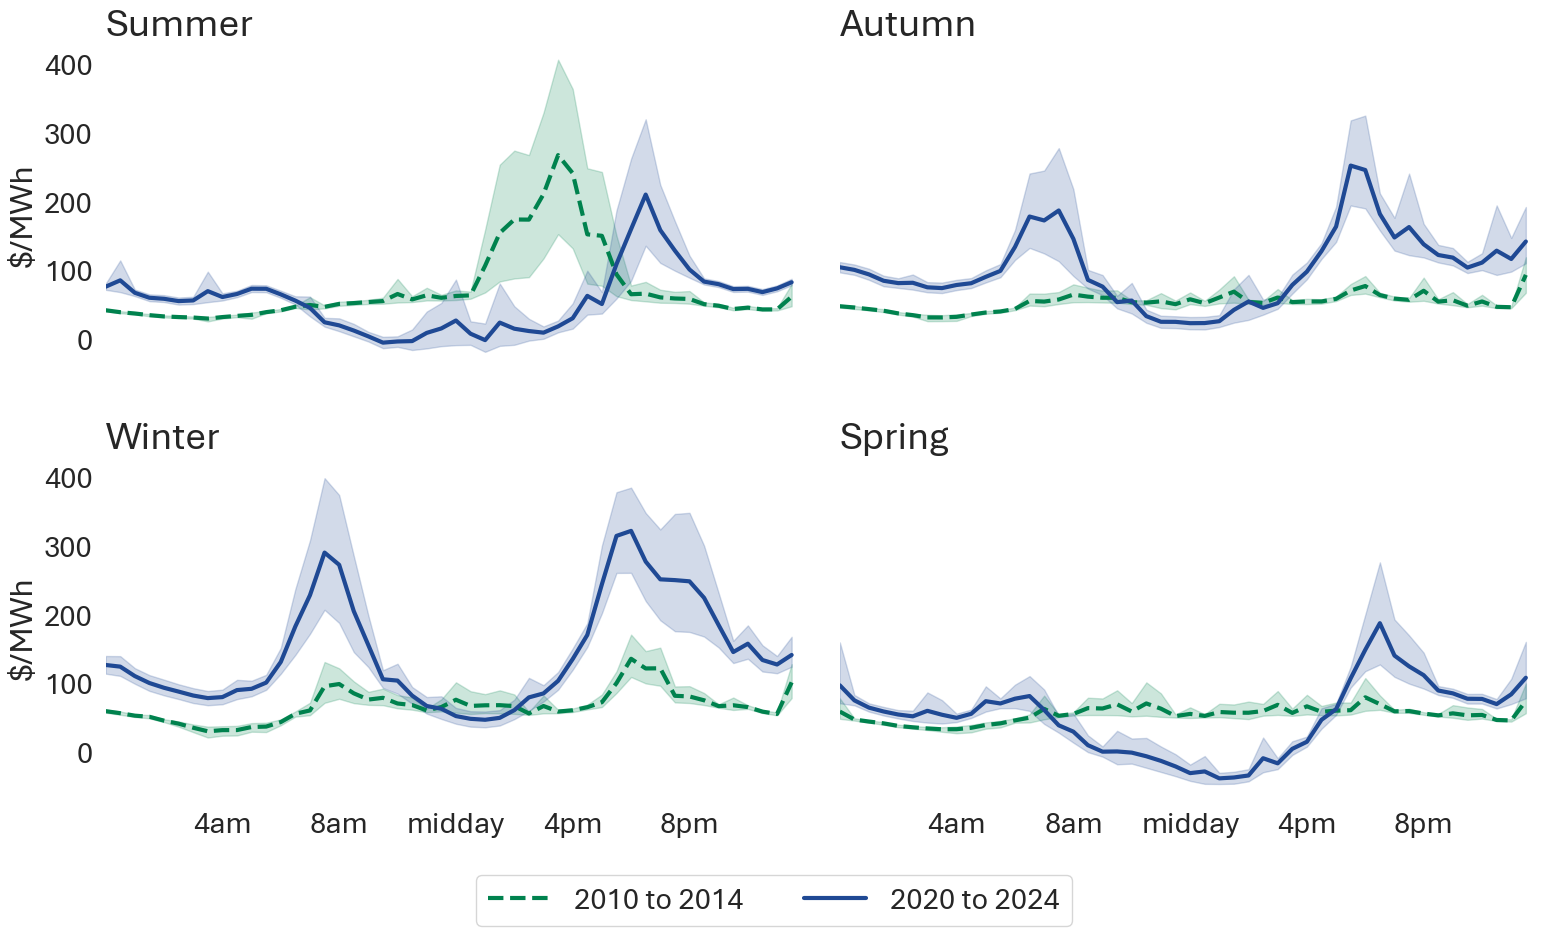

In [35]:
# Average seasonal and time-of-day spot prices in SA
sa_prices = pd.read_csv(
    os.path.join(data_dir, "nem_raw_prices_by_region_2006_to_2024.csv"),
    usecols=["Interval", "SA"],
    parse_dates=[0],
    index_col=0)
# Filter out unnecessary years
sa_prices = sa_prices.resample("30min").mean() # Resample to 30-minute spot prices
sa_prices = sa_prices.loc[sa_prices.index.map(lambda x : ((x.year >= 2010) & (x.year <= 2015)) | ((x.year >= 2020) & (x.year <= 2025)))]
sa_prices["Era"] = sa_prices.index.year.map(lambda x: "2010 to 2014" if x < 2020 else "2020 to 2024")
sa_prices["Interval number"] = [int(i.hour * 12 + i.minute / 5) for i in sa_prices.index]
sa_prices["Season"] = sa_prices.index.month.map(lambda x: "Summer" if x < 3 else "Autumn" if x < 6 else "Winter" if x < 9 else "Spring" if x < 12 else "Summer")
# Adjust for inflation
sa_prices["Quarter"] = sa_prices.index.to_period("Q")
sa_prices["Real price (2023 dollars)"] = (
    cpi_data.loc[sa_prices["Quarter"], "Real price adjustment"].values *
    sa_prices["SA"].values)
# New Index
sa_prices.index = range(len(sa_prices))
sa_prices = sa_prices[["Era", "Interval number", "Season", "Real price (2023 dollars)"]]
# Load Aurora data
aurora_base = pd.read_csv(
    os.path.join(data_dir, "Aurora", "20250604_Aurora_DCCEEW_HHprice_base_case.csv"),
    usecols=[4, 6, 10],
    header=0,
    names=["Month", "Time", "SA"]
)
aurora_base["Era"] = "2039-40"
aurora_base["Season"] = aurora_base["Month"].map(
    lambda m: "Summer" if (m > 11) | (m < 3)
    else "Autumn" if m < 6
    else "Winter" if m < 9
    else "Spring"
)
aurora_base["Interval number"] = aurora_base["Time"].map(
    lambda t: int(t.split(":")[0]) * 12
    + int(t.split(":")[1]) / 5
).astype(int)
aurora_base["Real price (2023 dollars)"] = aurora_base["SA"]
aurora_base = aurora_base[["Era", "Interval number", "Season", "Real price (2023 dollars)"]]
# Combine data
# sa_prices = pd.concat([sa_prices, aurora_base], ignore_index=True)
# Plot season and time of day prices
fig, ax = plt.subplots(
    2, 2,
    figsize=(16, 9),
    tight_layout=True,
    sharex=True,
    sharey=True)
# For legend
legend_lines = [
    mpl.lines.Line2D([], [], color="C2", linestyle='--', linewidth=3, label="2010 to 2014"),
    mpl.lines.Line2D([], [], color="C1", linewidth=3, label="2020 to 2024")]
    # mpl.lines.Line2D([], [], color="C3", linestyle=":", linewidth=3, label="2039-40")]
for i, season in enumerate(sa_prices["Season"].unique()):
    # seasonal data
    chart_data = sa_prices[            
        sa_prices["Season"] == season]
    axis = ax[i // 2, i % 2]
    early_plot = sns.lineplot(
        data=chart_data[chart_data["Era"] == "2010 to 2014"],
        x="Interval number",
        y="Real price (2023 dollars)",
        ax=axis,
        linewidth=3,
        color="C2",
        linestyle="--")
    later_plot = sns.lineplot(
        data=chart_data[chart_data["Era"] == "2020 to 2024"],
        x="Interval number",
        y="Real price (2023 dollars)",
        ax=axis,
        linewidth=3,
        color="C1")
    # Get data
    if season == "Spring":
        chart_data.pivot_table(
            index="Interval number",
            columns="Era",
            values="Real price (2023 dollars)",
            aggfunc="mean"
        ).to_clipboard()
    axis.set_xlabel(None)
    axis.set_ylabel("$/MWh")
    axis.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
    axis.set_xticks([48, 96, 144, 192, 240])
    axis.set_xticklabels(["4am", "8am", "midday", "4pm", "8pm"])
    axis.set_xlim(0, 287)
    axis.set_title(season, fontsize="large", fontweight="bold", loc="left")
    for frame in ["top", "left", "bottom", "right"]:
        axis.spines[frame].set_visible(False)
fig.legend(handles=legend_lines, loc="lower center", bbox_to_anchor=(0.5, -0.075), ncol=3)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

In [36]:
designer_data = sa_prices.pivot_table(
    index="Interval number",
    columns=["Era", "Season"],
    values="Real price (2023 dollars)")
designer_data.index = designer_data.index.map(lambda i: (dt.datetime(2025, 1, 1) + dt.timedelta(minutes=i / 6 * 30)).time())
designer_data.index = designer_data.index.map(lambda t: f"{t:%I:%M %p}")
designer_data.to_clipboard()

### Distribution of 30-minute real spot prices (2023 dollars) in South Australia, 2015 to 2024

In [37]:
# Average seasonal and time-of-day spot prices in SA
sa_prices = pd.read_csv(
    os.path.join(data_dir, "nem_raw_prices_by_region_2006_to_2024.csv"),
    usecols=["Interval", "SA"],
    parse_dates=[0],
    index_col=0)
# Filter out unnecessary years
sa_prices = sa_prices.resample("30min").mean() # Resample to 30-minute spot prices
sa_prices = sa_prices.loc[sa_prices.index.map(lambda x : x.year >= 2015)]
# Adjust for inflation
sa_prices["Quarter"] = sa_prices.index.to_period("Q")
sa_prices["Real price (2023 dollars)"] = (
    cpi_data.loc[sa_prices["Quarter"], "Real price adjustment"].values *
    sa_prices["SA"].values)

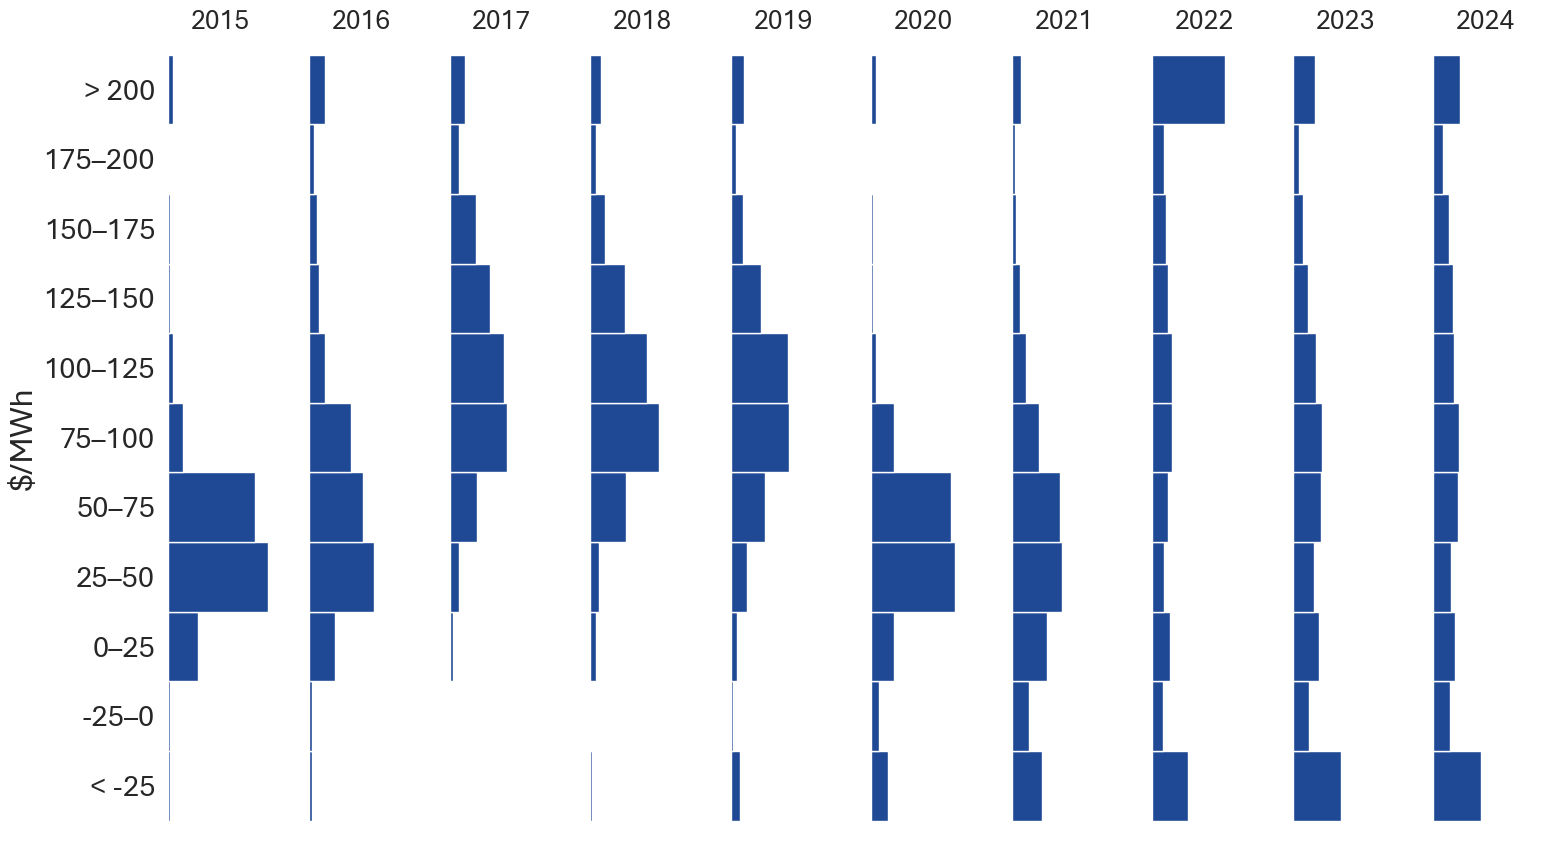

In [38]:
# Price bands over time
# Set years from 2015 to 2024
years = pd.date_range("2015", "2024", freq="YS")
# Set price bands
bands = [-float('inf')] + [i for i in range(-25, 225, 25)] + [float('inf')]
labels = ["< -25"] + [f"{i}–{i + 25}" for i in range(-25, 200, 25)] + ["> 200"]
# Plot chart
fig, ax = plt.subplots(
    1, 10,
    figsize=(16, 9),
    tight_layout=True,
    sharex=True,
    sharey=True)
# Iterate through years
designer_data = pd.DataFrame(
    columns=years,
    index=labels)
for i, year in enumerate(years):
    start = year
    end = year + pd.offsets.YearEnd() + pd.DateOffset(hours=23, minutes=30)
    chart_data = sa_prices.loc[start:end, "Real price (2023 dollars)"]
    hist_data = pd.cut(chart_data, bins=bands, labels=labels).value_counts().loc[labels]
    axis = ax[i]
    hist_data.plot(
        kind="barh",
        x=hist_data.values,
        y=hist_data.index,
        ax=axis,
        color="C1",
        width=1)
    axis.set_xlabel(None)
    axis.set_ylabel("$/MWh")
    axis.set_title(f"{year:%Y}", fontsize="small")
    axis.set_xticklabels([])
    # Remove spines
    for frame in ["top", "left", "bottom", "right"]:
        axis.spines[frame].set_visible(False)
    designer_data.iloc[:, i] = hist_data
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()
sa_prices.to_clipboard()

### Contribution of high, normal and negative prices to the annual real NEM price (2024 dollars) weighted by native demand, 2010 to 2024

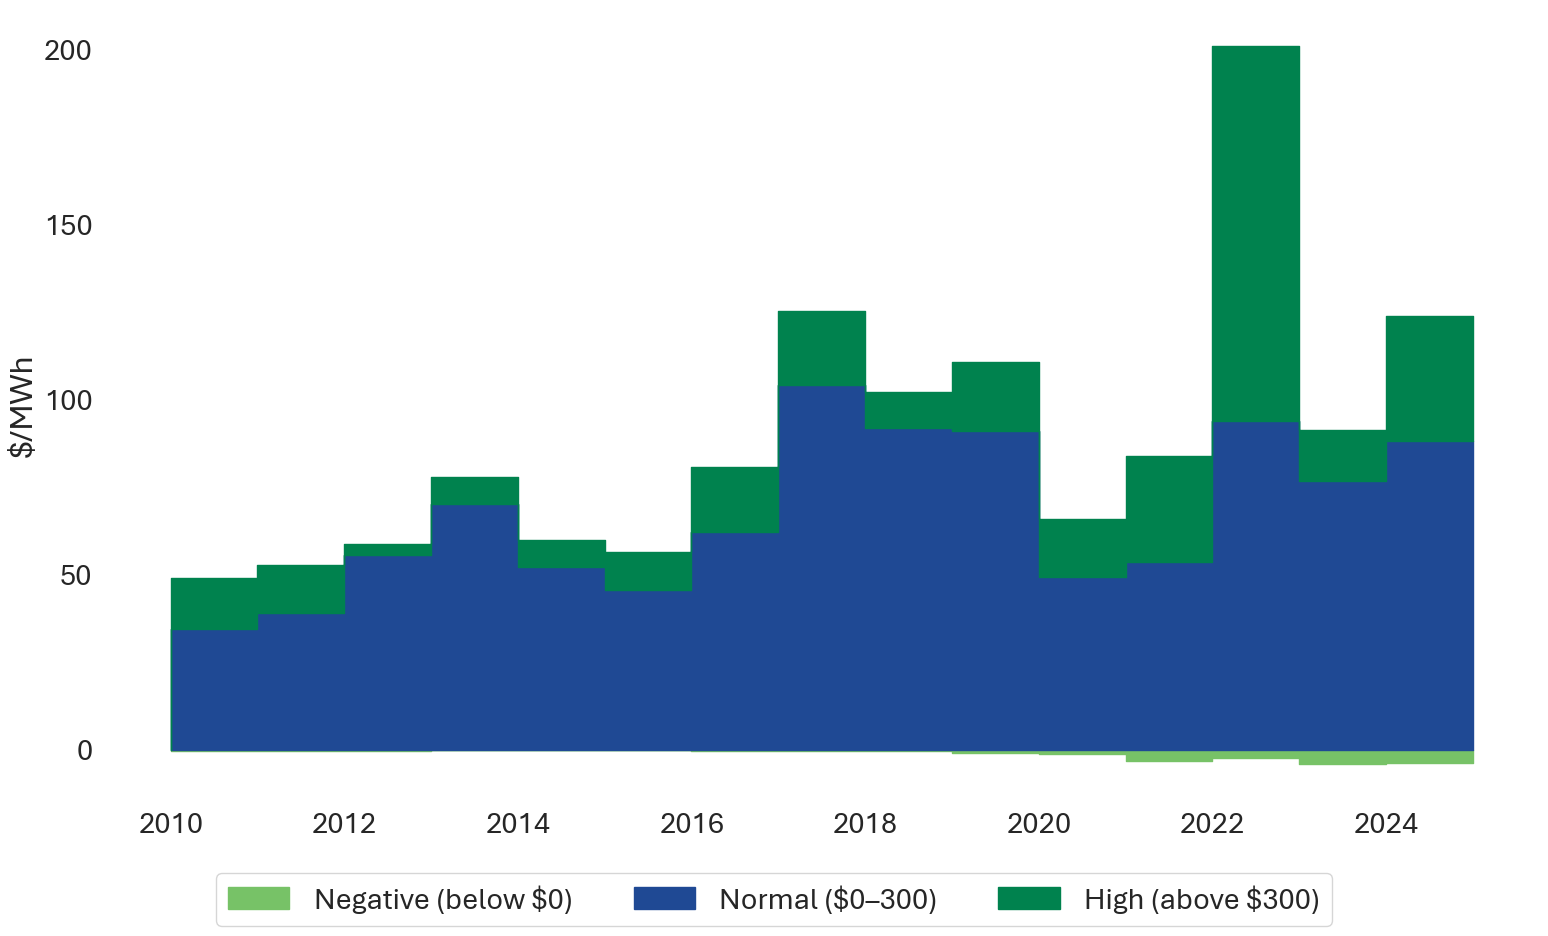

In [39]:
# Price contributions to NEM demand-weighted price
nem_prices = pd.read_csv(
    os.path.join(data_dir, "nem_raw_prices_and_demand_2006_to_2024.csv"),
    parse_dates=[0])
# Limited to relevant years
price_contributions = nem_prices.copy()[
    nem_prices["Interval"] >= "2010-01-01"]
price_contributions["Quarter"] = price_contributions["Interval"].dt.to_period("Q")
# Adjust for inflation
price_contributions["Real price (2023 dollars)"] = (
    cpi_data.loc[price_contributions["Quarter"], "Real price adjustment"].values *
    price_contributions["Price"].values)
price_contributions["Year"] = price_contributions["Interval"].dt.year
price_contributions["Revenue"] = price_contributions["Native demand"] * price_contributions["Real price (2023 dollars)"]
price_contributions["High revenue"] = price_contributions["Revenue"].where(price_contributions["Real price (2023 dollars)"] > 300, 0)
price_contributions["Normal revenue"] = price_contributions["Revenue"].where((price_contributions["Real price (2023 dollars)"] >= 0) & (price_contributions["Real price (2023 dollars)"] <= 300), 0)
price_contributions["Negative revenue"] = price_contributions["Revenue"].where(price_contributions["Real price (2023 dollars)"] < 0, 0)
price_contributions = price_contributions.groupby("Year").agg(
    HighRevenue=("High revenue", "sum"),
    NormalRevenue=("Normal revenue", "sum"),
    NegativeRevenue=("Negative revenue", "sum"),
    TotalRevenue=("Revenue", "sum"),
    TotalDemand=("Native demand", "sum")
).reset_index()
price_contributions["Negative (below $0)"] = price_contributions["NegativeRevenue"] / price_contributions["TotalDemand"]
price_contributions["Normal ($0–300)"] = price_contributions["NormalRevenue"] / price_contributions["TotalDemand"]
price_contributions["High (above $300)"] = price_contributions["HighRevenue"] / price_contributions["TotalDemand"]
price_contributions["Year"] = pd.to_datetime(price_contributions["Year"], format="%Y") + pd.offsets.YearEnd()
# Save local copy
price_contributions.to_csv(os.path.join(data_dir, "real_nem_price_by_contribution_by_year.csv"))

# Stacked column chart
chart_data = price_contributions.copy().set_index("Year").iloc[:, -3:].cumsum(axis=1)
# Append initial row of 0s
chart_data.loc[pd.to_datetime("2009-12-31")] = [0, 0, 0]
chart_data.sort_index(inplace=True)
fig, ax = plt.subplots(
    figsize=(16, 9),
    tight_layout=True)
for i, band in enumerate(chart_data.columns):
    ax.fill_between(
        x=chart_data.index,
        y1=chart_data[band],
        y2=(0 if i < 2 else chart_data.iloc[:, 1]),
        color=("C1" if i == 1 else "C2" if i == 2 else "C3"),
        label=band,
        step="pre")
plt.xlabel(None)
plt.ylabel("$/MWh")
ax.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
for frame in ["top", "left", "bottom", "right"]:
    ax.spines[frame].set_visible(False)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.075), ncol=4)
plt.show()
price_contributions.to_clipboard()

### Forecast New South Wales real (2023 dollars) time-weighted-average 30-minute spot price distribution in 2040 in different commodity and weather scenarios

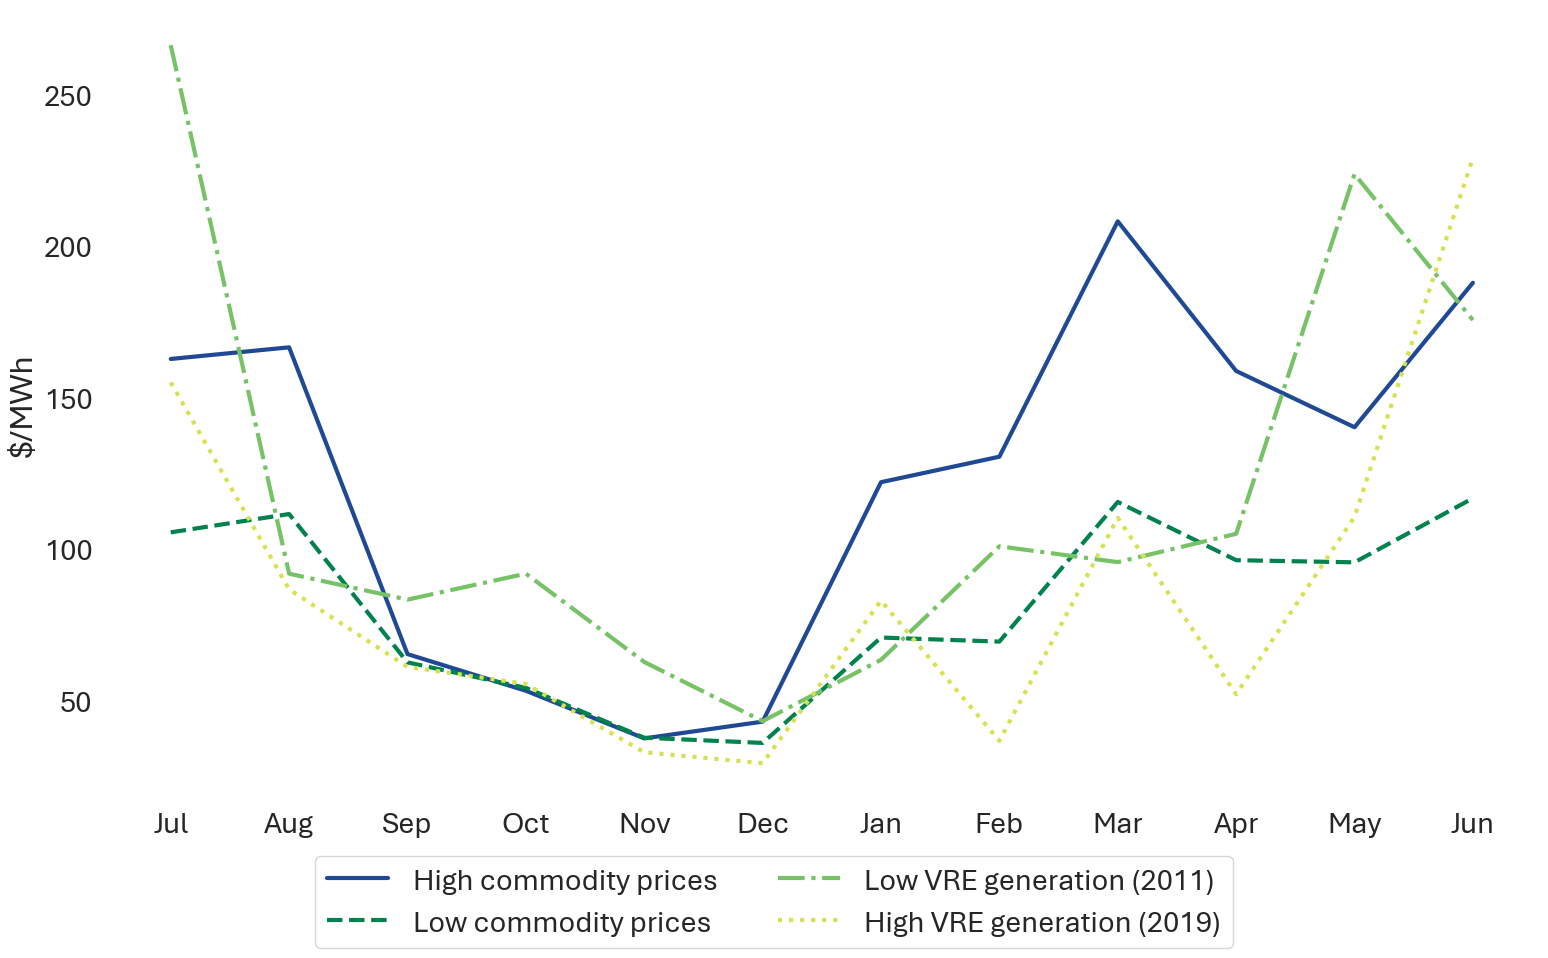

In [40]:
# Load data
price_data = pd.read_csv(
    os.path.join(data_dir, "price_scenarios_2040.tsv"),
    sep="\t",
    index_col=0)
price_data = price_data.reset_index().melt(
    id_vars=["Month"],
    value_vars=price_data.columns,
    var_name="Scenario",
    value_name="Price")
price_data["Month"] = price_data["Month"].map(lambda x: x[:3])

# Plot chart
fig, ax = plt.subplots(
    figsize=(16, 9),
    tight_layout=True)
for i, scenario in enumerate(price_data["Scenario"].unique()):
    plot_data = price_data[price_data["Scenario"] == scenario]
    ax.plot(
        plot_data["Month"],
        plot_data["Price"],
        linewidth=3,
        color=f"C{i + 1}",
        label=scenario,
        linestyle=["-", "--", "-.", ":"][i])
plt.xlabel(None)
plt.ylabel("$/MWh")
for frame in ["top", "left", "bottom", "right"]:
    ax.spines[frame].set_visible(False)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.show()

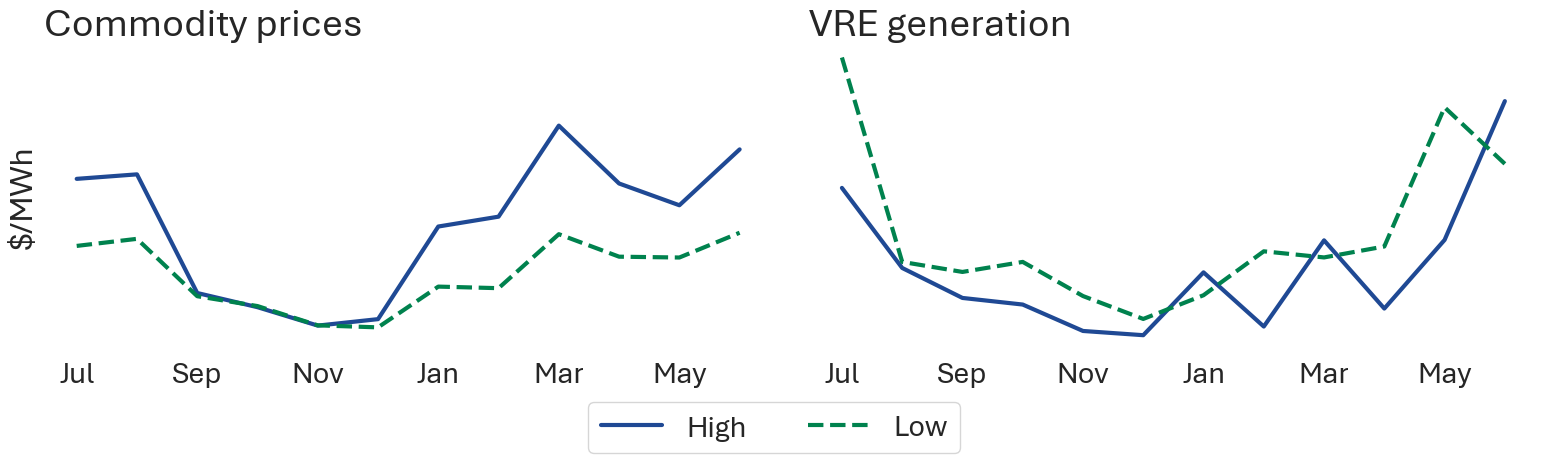

In [41]:
# Plot chart
fig, ax = plt.subplots(
    1, 2,
    figsize=(16, 9 / 2),
    tight_layout=True,
    sharey=True)
# Commodity prices
plot_data = price_data[price_data["Scenario"] == "High commodity prices"]
ax[0].plot(
    plot_data["Month"],
    plot_data["Price"],
    linewidth=3,
    color="C1",
    label="High")
plot_data = price_data[price_data["Scenario"] == "Low commodity prices"]
ax[0].plot(
    plot_data["Month"],
    plot_data["Price"],
    linewidth=3,
    color="C2",
    linestyle="--",
    label="Low")
ax[0].set_xlabel(None)
ax[0].set_xticks(ax[0].get_xticks()[::2])
ax[0].set_ylabel("$/MWh")
ax[0].set_yticks([])
ax[0].set_title("Commodity prices", loc="left", fontsize="large")
# Weather
plot_data = price_data[price_data["Scenario"] == "High VRE generation (2019)"]
ax[1].plot(
    plot_data["Month"],
    plot_data["Price"],
    linewidth=3,
    color="C1",
    label="High")
plot_data = price_data[price_data["Scenario"] == "Low VRE generation (2011)"]
ax[1].plot(
    plot_data["Month"],
    plot_data["Price"],
    linewidth=3,
    color="C2",
    linestyle="--",
    label="Low")
ax[1].set_xlabel(None)
ax[1].set_title("VRE generation", loc="left", fontsize="large")
ax[1].set_xticks(ax[1].get_xticks()[::2])
ax[1].set_yticks([])
for frame in ["top", "left", "bottom", "right"]:
    ax[0].spines[frame].set_visible(False)
    ax[1].spines[frame].set_visible(False)
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.show()
price_data.to_clipboard()

### Annual NEM-wide mean absolute differences of pre-dispatch price forecast errors (2023 dollars), 2010 to 2024

In [42]:
# Get short-term data form the MMS
st_data = get_mms_data(
    "predispatch_5m_30m",
    {"start_date": "2010-01-01",
     "end_date": "2024-12-31"})
# Alter interval time to start rather than end
st_data["Interval"] = st_data["Interval"] - pd.DateOffset(minutes=5)

In [43]:
# Adjust for inflation
st_data["Quarter"] = st_data["Interval"].dt.to_period("Q")
st_data["Year"] = st_data["Quarter"].dt.year
# Adjust for inflation
st_data["Real price"] = (
    cpi_data.loc[st_data["Quarter"], "Real price adjustment"].values *
    st_data["Price"].values)
st_data["Real 5-min forecast"] = (
    cpi_data.loc[st_data["Quarter"], "Real price adjustment"].values *
    st_data["5-min forecast"].values)
st_data["Real 30-min forecast"] = (
    cpi_data.loc[st_data["Quarter"], "Real price adjustment"].values *
    st_data["30-min forecast"].values)
# Calculate errors
st_data["5-min error"] = (st_data["Real 5-min forecast"] - st_data["Real price"])
st_data["30-min error"] = (st_data["Real 30-min forecast"] - st_data["Real price"])
# Save data
st_data.to_csv(os.path.join("predispatch_errors_5min_5min_2010_to_2024.csv"), index=False)
st_data

,Interval,Region,Price,5-min forecast,30-min forecast,Quarter,Year,Real price,Real 5-min forecast,Real 30-min forecast,5-min error,30-min error
0,2010-01-01 00:00:00,NSW,21.99897,22.00036,21.99922,2010Q1,2010,30.895612,30.897564,30.895963,0.001952,0.000351
1,2010-01-01 00:05:00,NSW,21.99922,21.99922,21.99922,2010Q1,2010,30.895963,30.895963,30.895963,0.000000,0.000000
2,2010-01-01 00:10:00,NSW,21.99911,21.99900,21.99922,2010Q1,2010,30.895809,30.895654,30.895963,-0.000154,0.000154
3,2010-01-01 00:15:00,NSW,20.99944,21.66318,21.99886,2010Q1,2010,29.491861,30.424025,30.895458,0.932164,1.403597
4,2010-01-01 00:20:00,NSW,21.00000,21.00000,21.99922,2010Q1,2010,29.492647,29.492647,30.895963,0.000000,1.403316
...,...,...,...,...,...,...,...,...,...,...,...,...
7889750,2024-12-31 23:35:00,VIC,120.61544,119.31746,116.13959,2024Q4,2024,115.683532,114.438626,111.390697,-1.244906,-4.292835
7889751,2024-12-31 23:40:00,VIC,130.00000,119.60179,102.58057,2024Q4,2024,124.684362,114.711329,98.386099,-9.973032,-26.298262
7889752,2024-12-31 23:45:00,VIC,120.09134,121.02032,107.84655,2024Q4,2024,115.180862,116.071856,103.436756,0.890994,-11.744106
7889753,2024-12-31 23:50:00,VIC,122.56345,112.66876,107.72390,2024Q4,2024,117.551889,108.061788,103.319121,-9.490101,-14.232768


In [44]:
# Absolute errors
st_data.loc[:, "5-min error":"30-min error"] = st_data.loc[:, "5-min error":"30-min error"].abs()
st_errors = st_data.pivot_table(
    index="Year",
    values=["5-min error", "30-min error"])

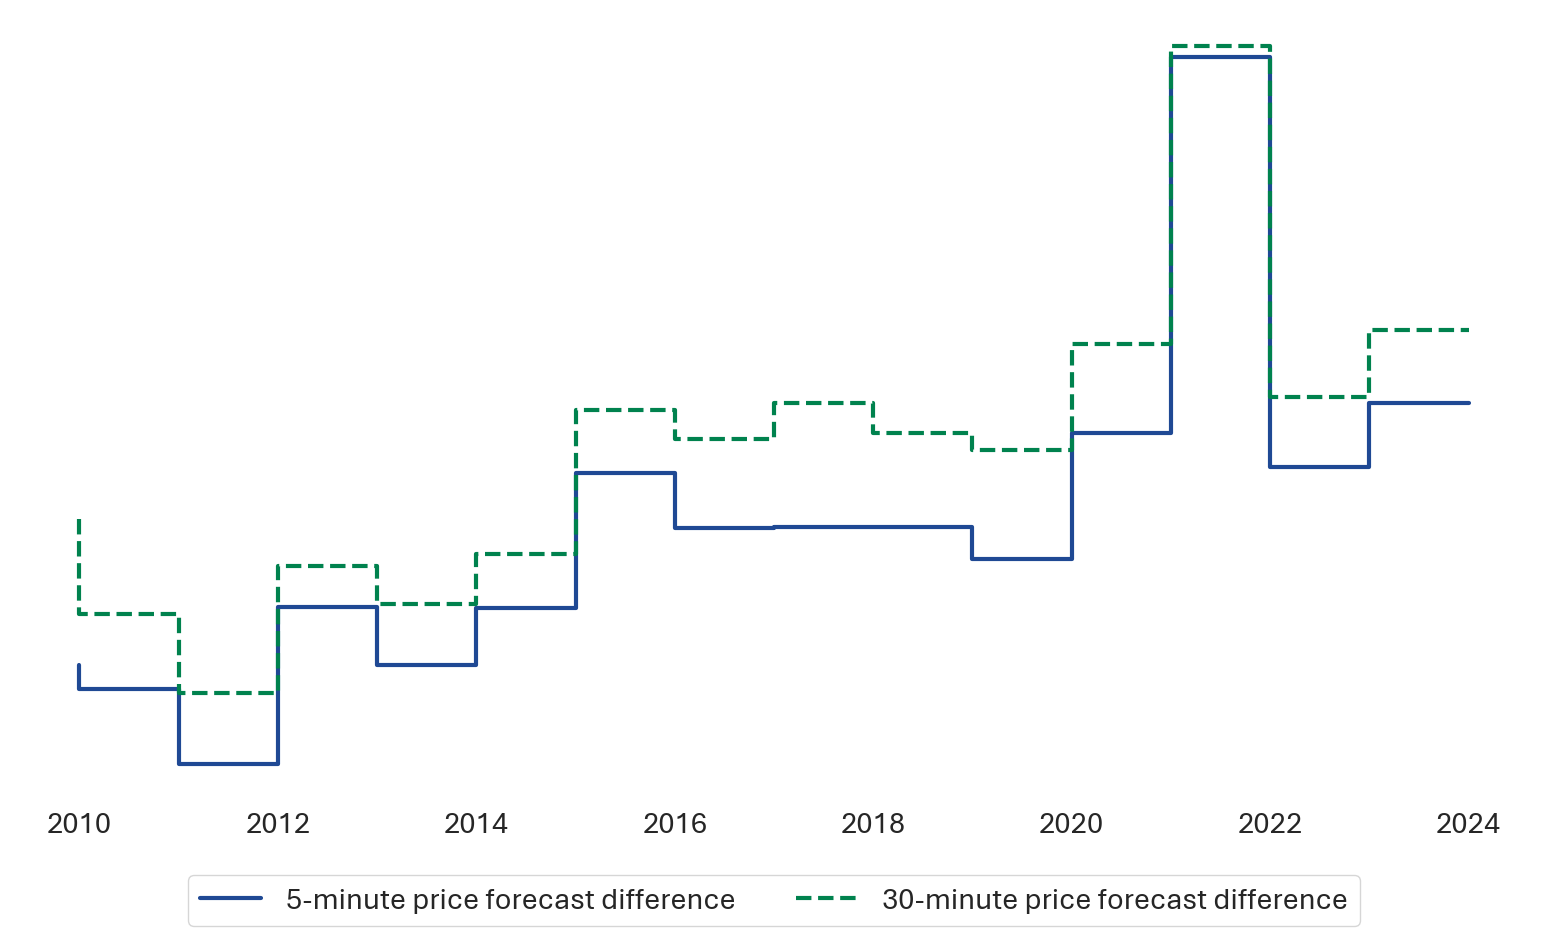

In [45]:
# Plot chart
fig, ax = plt.subplots(
    figsize=(16, 9),
    tight_layout=True)
plot_data = price_data[price_data["Scenario"] == scenario]
ax.step(
    x=st_errors.index,
    y=st_errors["5-min error"],
    linewidth=3,
    where="pre",
    color="C1",
    label="5-minute price forecast difference")
ax.step(
    x=st_errors.index,
    y=st_errors["30-min error"],
    linewidth=3,
    where="pre",
    color="C2",
    label="30-minute price forecast difference",
    linestyle="--")
plt.xlabel(None)
# plt.ylabel("$/MWh (log scale)")
plt.yscale("log")
ax.set_yticks([])
for frame in ["top", "left", "bottom", "right"]:
    ax.spines[frame].set_visible(False)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.075), ncol=2)
plt.show()
st_errors.to_clipboard()

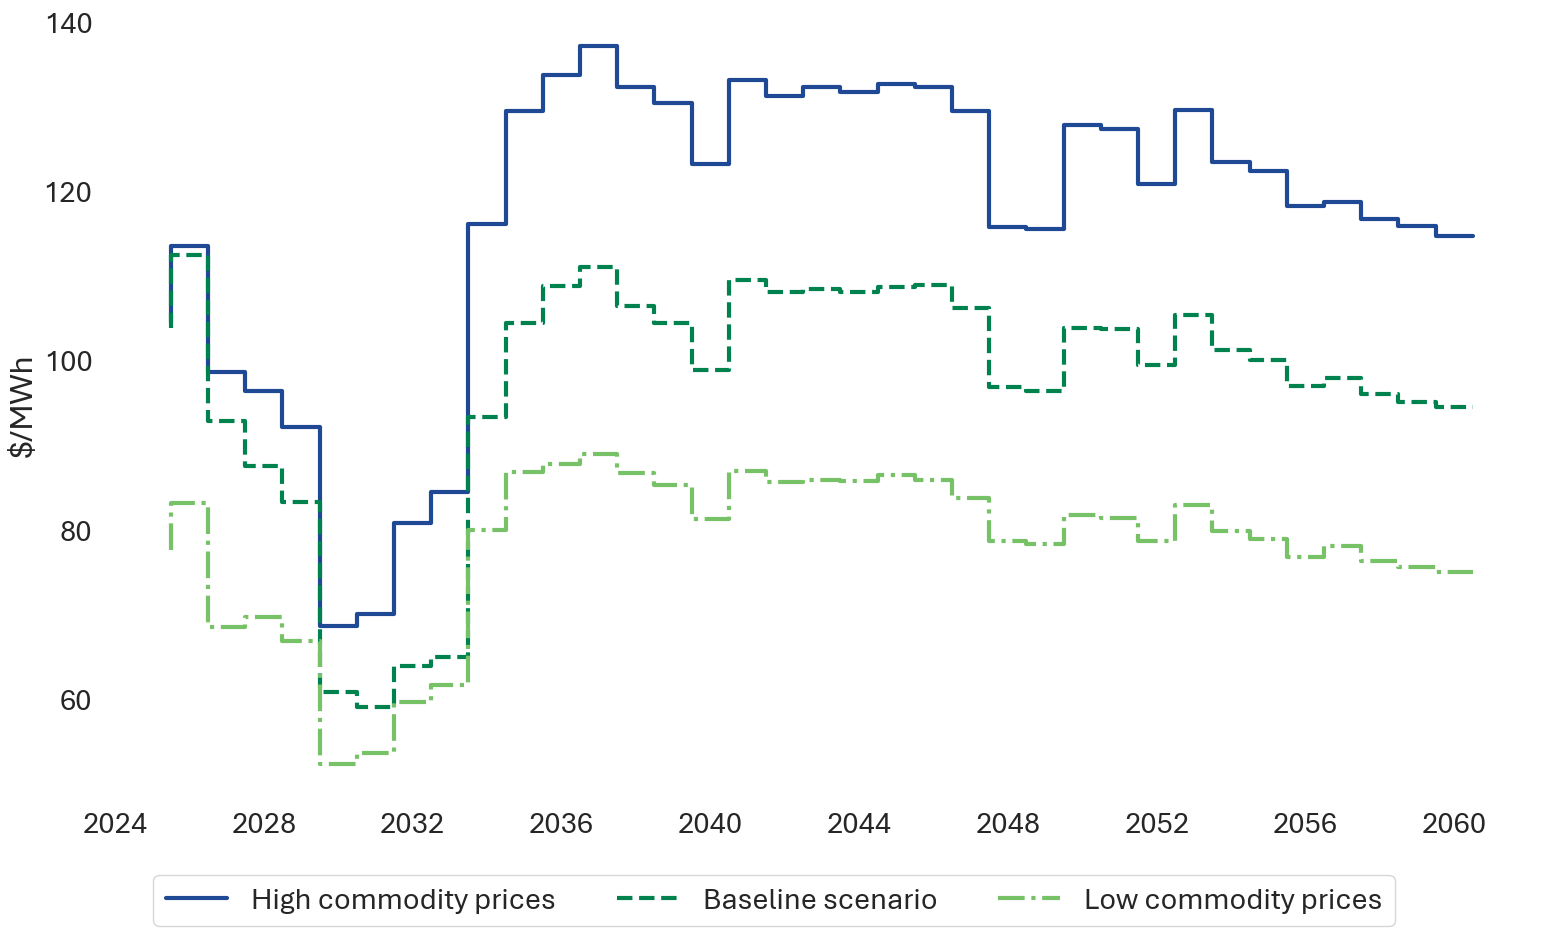

In [46]:
# Load data
chart_data = pd.read_csv(
    os.path.join(data_dir, "commodity_price_scenarios.tsv"),
    sep="\t",
    index_col=0)
chart_data.index = chart_data.index.map(lambda y: pd.to_datetime(f"{y}-06-30"))

# Plot chart
fig, ax = plt.subplots(
    figsize=(16, 9),
    tight_layout=True)
for i, scenario in enumerate(chart_data.columns):
    ax.step(
        x=chart_data.index,
        y=chart_data[scenario],
        linewidth=3,
        # where="pre",
        color=f"C{i + 1}",
        label=scenario,
        linestyle=["-", "--", "-."][i])
plt.xlabel(None)
plt.ylabel("$/MWh")
for frame in ["top", "left", "bottom", "right"]:
    ax.spines[frame].set_visible(False)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.075), ncol=3)
plt.show()

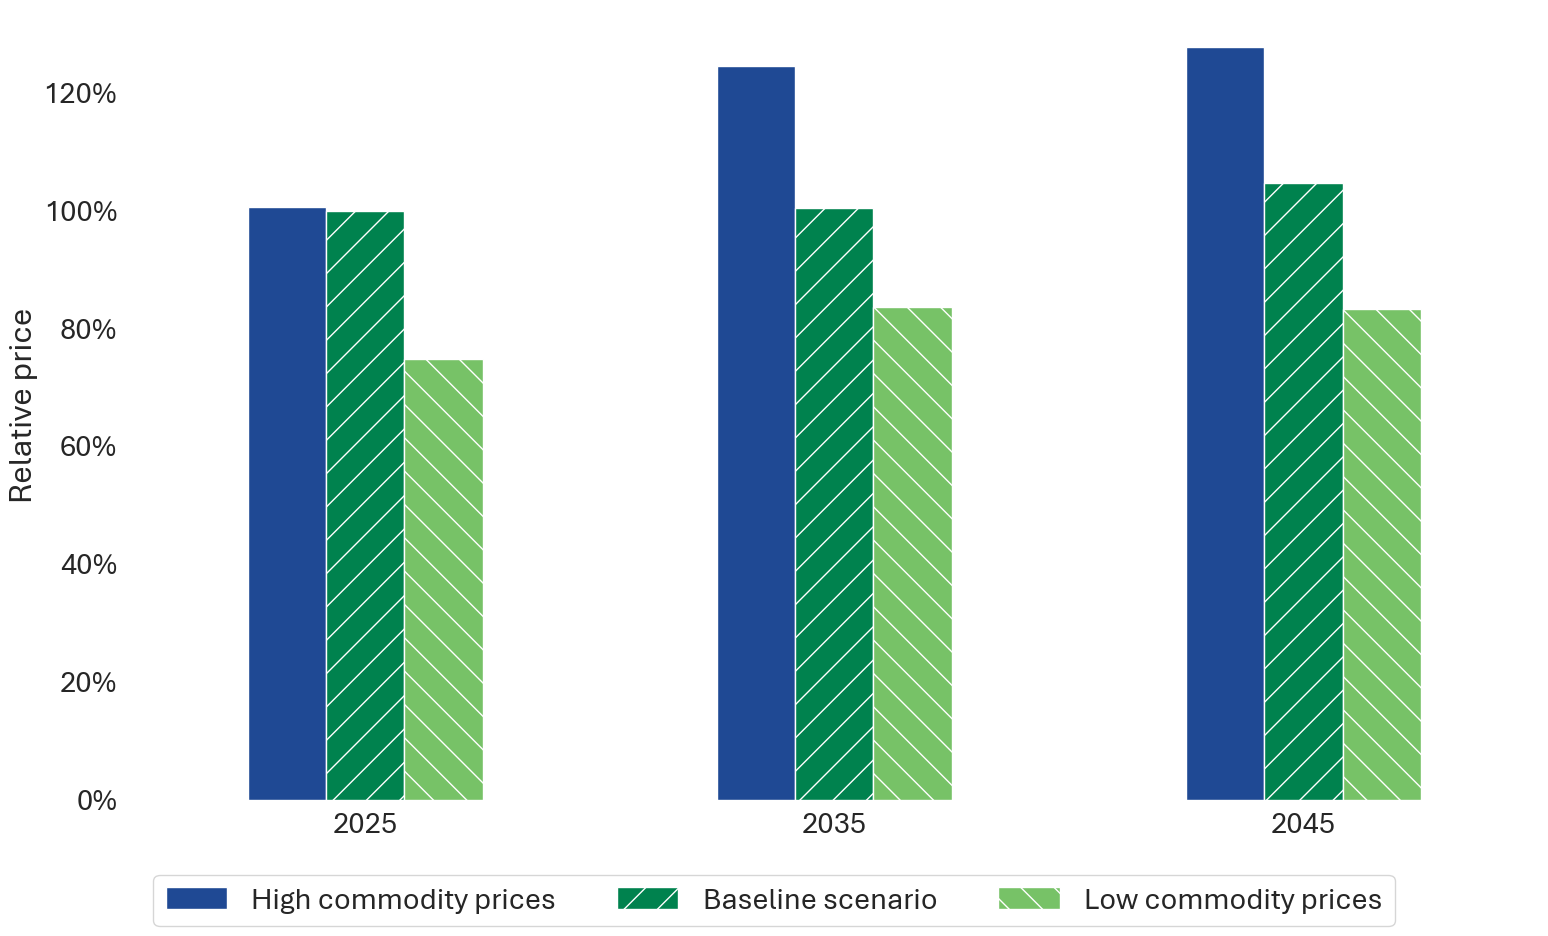

In [47]:
new_chart_data = chart_data.copy().loc[["2025-06-30", "2035-06-30", "2045-06-30"]]
new_chart_data = new_chart_data / new_chart_data.iat[0, 1]

# Plot chart
fig, ax = plt.subplots(
    figsize=(16, 9),
    tight_layout=True)
new_chart_data.plot(
    kind="bar",
    color=palette,
    ax=ax,
    width=.5)
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1))
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(["2025", "2035", "2045"], rotation=0)
plt.xlabel(None)
plt.ylabel("Relative price")
for frame in ["top", "left", "bottom", "right"]:
    ax.spines[frame].set_visible(False)
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
# Iterate over the bars and set the hatch pattern
hatch_patterns = [None, "/", "\\"]
for i, bars in enumerate(ax.containers):
    for bar in bars:
        bar.set_hatch(hatch_patterns[i])
fig.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.075), ncol=3)
plt.show()
new_chart_data.to_clipboard()

### Projected coal power station closures, 2009-10 to 2049-50

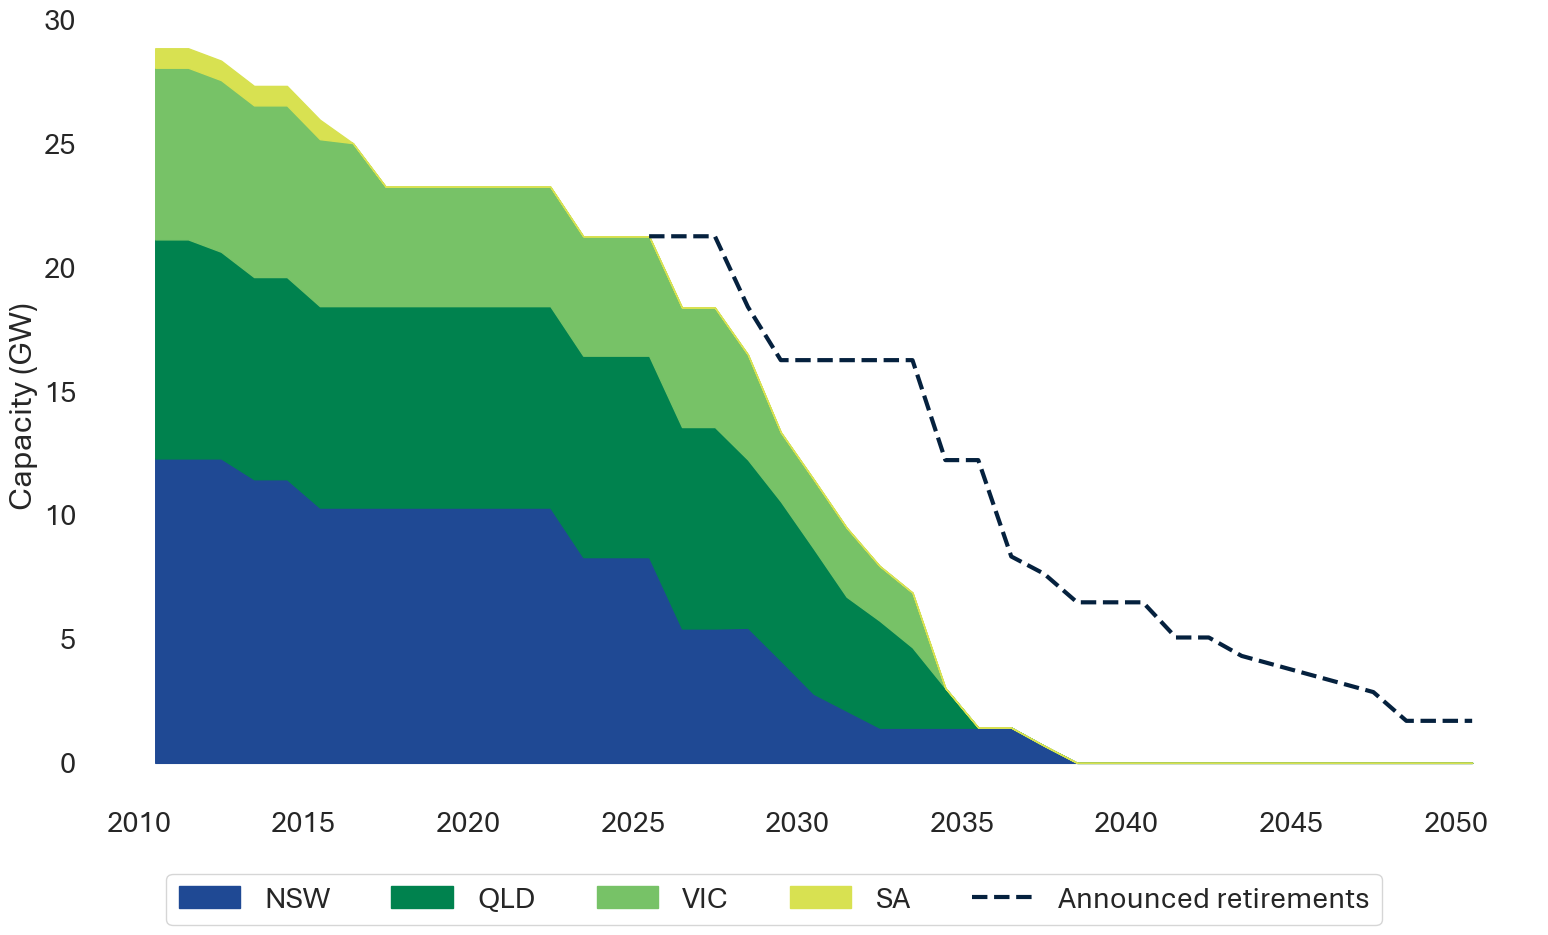

In [48]:
# Load data
coal_data = pd.read_excel(
    os.path.join(data_dir, "coal_closures.xlsx"),
    usecols=[0, 1, 2, 3, 4, 8])
# Convert year
coal_data["Year"] = coal_data["Year"].map(lambda y: pd.to_datetime(f"{y[:2]}{y[-2:]}-06-30"))
coal_data.set_index("Year", inplace=True)

# Plot chart
fig, ax = plt.subplots(
    figsize=(16, 9),
    tight_layout=True)
for i, state in enumerate(coal_data.columns[:4]):
    ax.fill_between(
        x=coal_data.index,
        y1=coal_data.cumsum(axis=1)[state],
        y2=(0 if i == 0 else coal_data.cumsum(axis=1).iloc[:, i - 1]),
        color=f"C{i + 1}",
        label=state)
ax.plot(
    coal_data.index,
    coal_data["Announced retirements"],
    color="C0",
    linewidth=3,
    linestyle="--",
    label="Announced retirements")
plt.ylabel("Capacity (GW)")
plt.xlabel(None)
ax.yaxis.set_major_formatter(lambda c, p: f"{c / 1000:,.0f}")
for frame in ["top", "left", "bottom", "right"]:
    ax.spines[frame].set_visible(False)
handles, labels = ax.get_legend_handles_labels()
# ax.get_legend().remove()
fig.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.075), ncol=5)
plt.show()
coal_data.to_clipboard()

### Volume of electricity futures contracts traded on the ASX, 2010 to 2024

In [49]:
# Load data
raw_asx_data = pd.read_excel(
    os.path.join(data_dir, "asx_traded_volumes.xlsx"),
    header=(0, 1))
# Clean data
asx_data = pd.DataFrame(
    columns=["Quarter", "Region", "Contract", "Volume"])
for i, row in raw_asx_data.iterrows():
    # Establish quarter
    if pd.notna(row[row.index[0]]):
        year = int(row[row.index[0]])
    quarter_no = int(row[row.index[1]])
    quarter = dt.datetime(year, quarter_no * 3, 1) + pd.offsets.MonthEnd()
    # Establish contract and region
    for column in row.index[2:]:
        region = column[0]
        contract = column[1][0] + column[1][1:].lower()
        volume = row[column]
        asx_data.loc[len(asx_data)] = [
            quarter,
            region,
            contract,
            volume]

trade_data = asx_data.pivot_table(
    index="Quarter",
    columns="Region",
    values="Volume",
    aggfunc="sum")
trade_data = trade_data.loc["2009-01-01":"2024-12-31"]
trade_data

Region,NSW,QLD,SA,VIC
Quarter,,,,
2009-03-31,18444885.0,22053273.0,41160.0,24720699.0
2009-06-30,32468547.0,26879928.0,962880.0,20143926.0
2009-09-30,26615130.0,28340184.0,690096.0,31999539.0
2009-12-31,31687836.0,28173102.0,1958448.0,34268466.0
2010-03-31,28913496.0,21302802.0,1621752.0,39208722.0
...,...,...,...,...
2023-12-31,114610254.0,134701992.0,1249224.0,101823681.0
2024-03-31,77463096.0,85090248.0,1722624.0,98114136.0
2024-06-30,99043704.0,102953160.0,451128.0,103907403.0


<Axes: xlabel='Quarter', ylabel='Volume'>

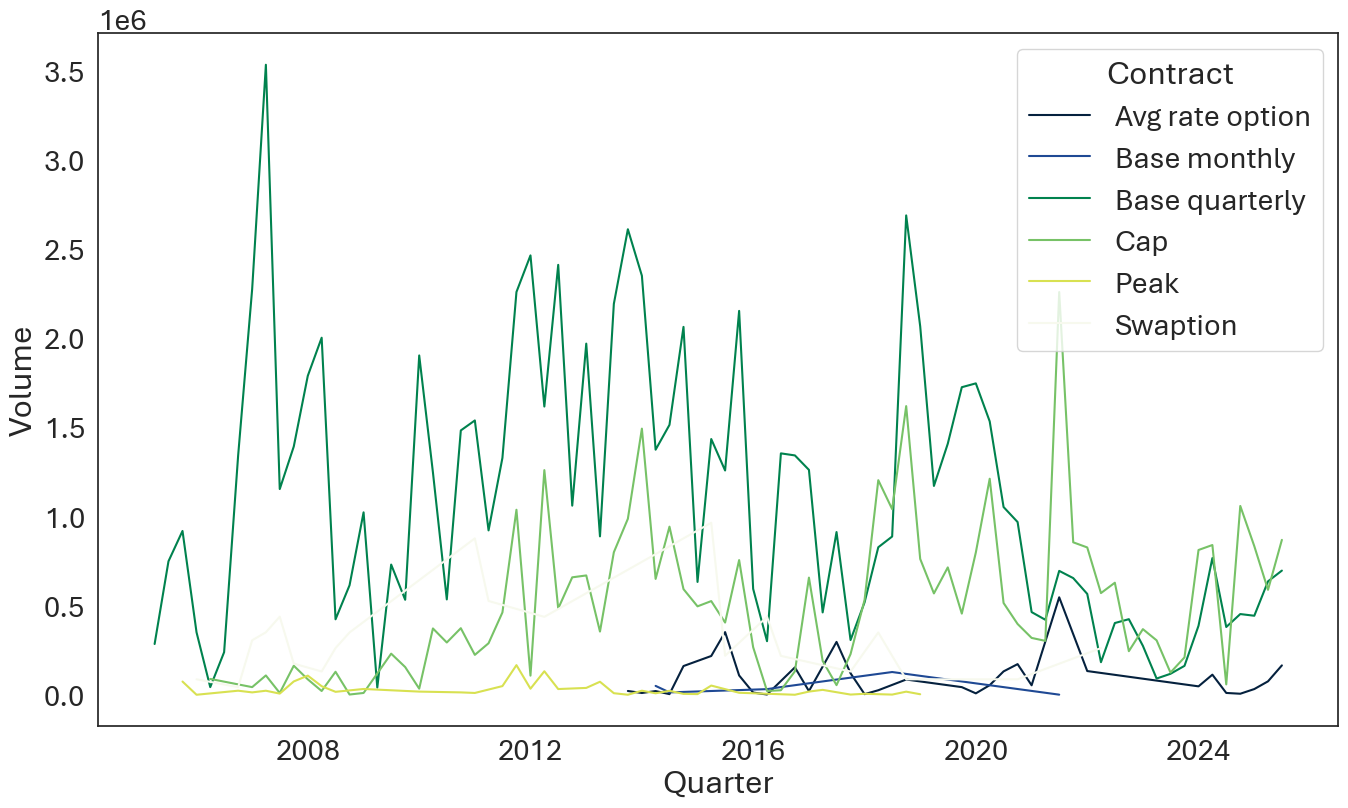

In [50]:
sa = asx_data[asx_data.Region == "SA"]
fig = plt.figure(figsize=(16, 9))
sns.lineplot(
    data=sa,
    x="Quarter",
    y="Volume",
    hue="Contract")

In [51]:
# Get native demand data
raw_demand_data = get_mms_data(
    "native_demand",
    {"start_date": "2009-01-01",
     "end_date": "2024-12-31"})
# Correct 5-minute lag
raw_demand_data["Interval"] = raw_demand_data["Interval"] - pd.DateOffset(minutes=5)
# Convert from MW to MWh
raw_demand_data["Native demand (MWh)"] = raw_demand_data["Native demand"] / 12
demand_data = raw_demand_data.pivot_table(
    index="Interval",
    columns="Region",
    values="Native demand (MWh)",
    aggfunc="sum").resample("QE").sum()
demand_data

Region,NSW,QLD,SA,TAS,VIC
Interval,,,,,
2009-03-31,1.939174e+07,1.364577e+07,3.700921e+06,2.512197e+06,1.275970e+07
2009-06-30,1.935514e+07,1.271648e+07,3.555030e+06,2.744310e+06,1.308699e+07
2009-09-30,2.007799e+07,1.287141e+07,3.656731e+06,2.983868e+06,1.345610e+07
2009-12-31,1.944000e+07,1.384430e+07,3.580378e+06,2.636065e+06,1.293949e+07
2010-03-31,1.948895e+07,1.393646e+07,3.656685e+06,2.535732e+06,1.293782e+07
...,...,...,...,...,...
2023-12-31,1.574492e+07,1.393104e+07,2.444260e+06,2.553743e+06,9.692639e+06
2024-03-31,1.697554e+07,1.540230e+07,2.818969e+06,2.495046e+06,1.008932e+07
2024-06-30,1.750158e+07,1.368908e+07,3.062995e+06,2.801258e+06,1.168125e+07


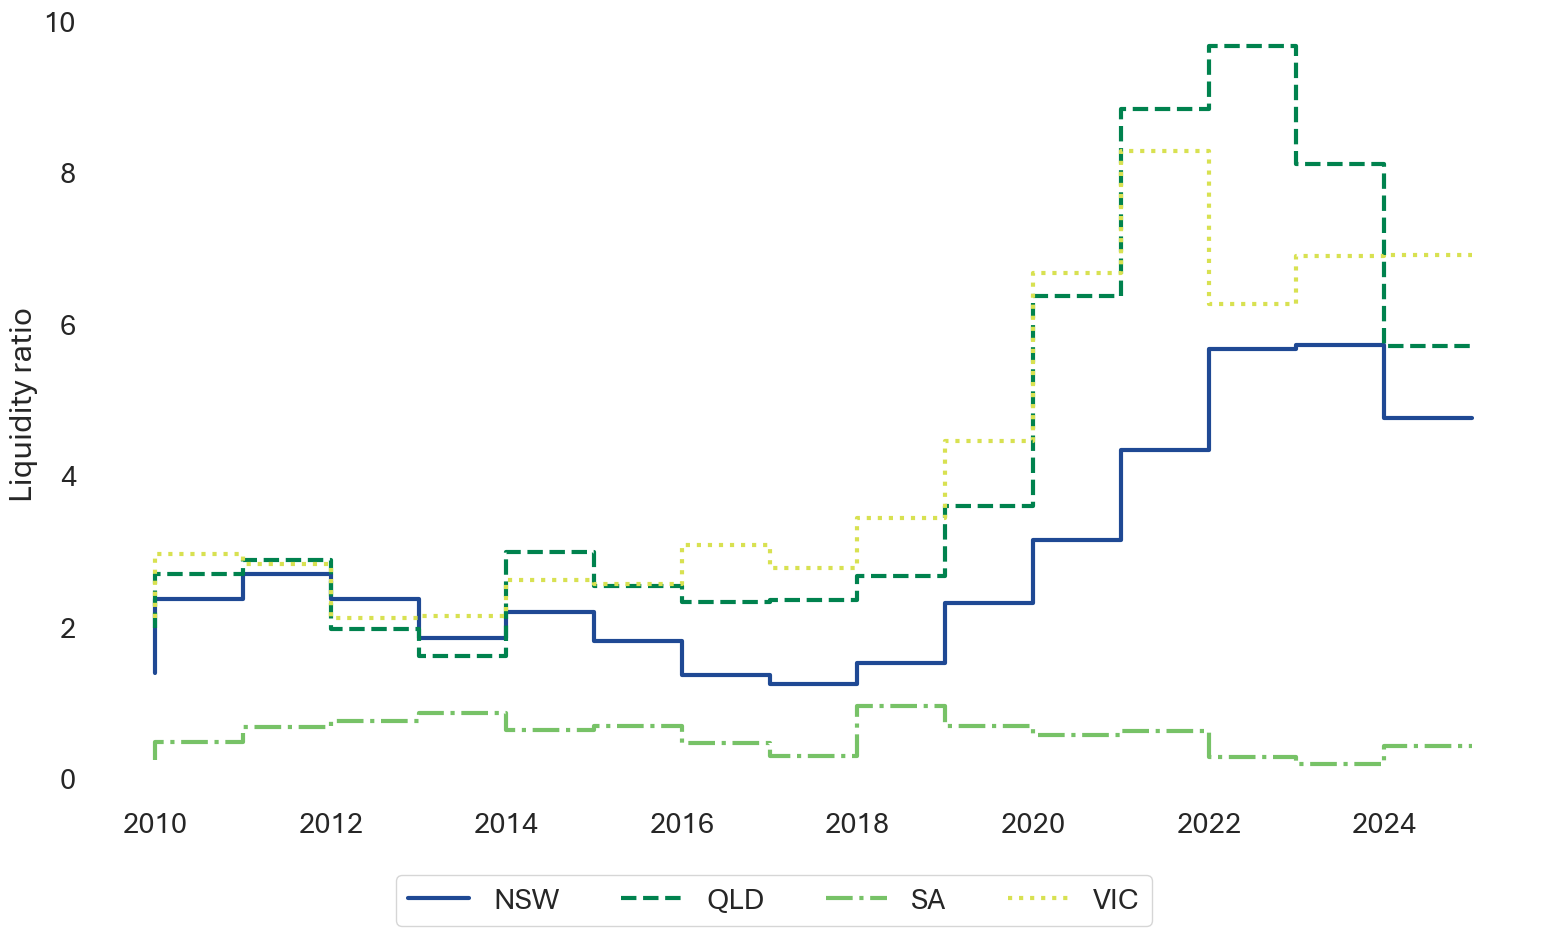

In [61]:
# Plot chart
fig, ax = plt.subplots(
    figsize=(16, 9),
    tight_layout=True)
regions = ["NSW", "QLD", "SA", "VIC"]
chart_data = (trade_data[regions].resample("YE").sum() / demand_data[regions].resample("YE").sum())
for i, region in enumerate(chart_data.columns):
    ax.step(
        x=chart_data.index,
        y=chart_data[region],
        linewidth=3,
        linestyle=["-", "--", "-.", ":"][i],
        color=f"C{i + 1}",
        label=region)
for frame in ["top", "right", "bottom", "left"]:
    ax.spines[frame].set_visible(False)
handles, labels = ax.get_legend_handles_labels()
plt.xlabel(None)
plt.ylabel("Liquidity ratio")
fig.legend(
    handles=handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.075),
    ncols=4)
plt.show()
chart_data.to_clipboard()

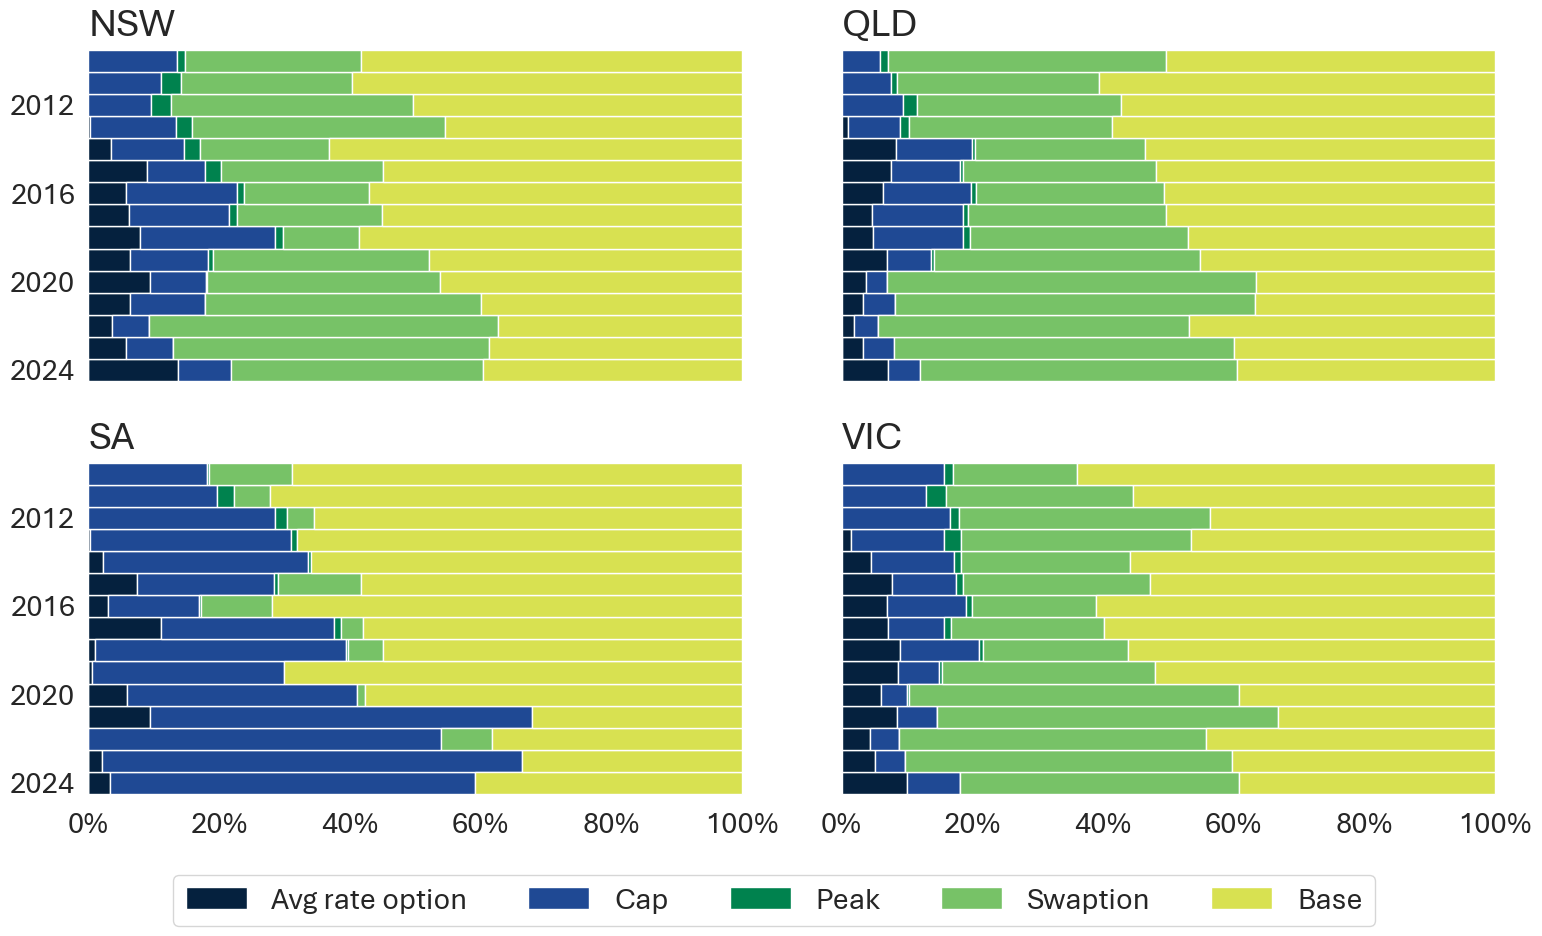

In [53]:
# Plot chart
fig, ax = plt.subplots(
    2, 2,
    figsize=(16, 9),
    tight_layout=True,
    sharex=True,
    sharey=True)
regions = ["NSW", "QLD", "SA", "VIC"]
for i, region in enumerate(regions):
    axis = ax[i // 2, i % 2]
    chart_data = asx_data[
        asx_data["Region"] == region].copy()
    chart_data["Year"] = chart_data["Quarter"].dt.year
    chart_data = chart_data.pivot_table(
        index="Year",
        columns="Contract",
        values="Volume",
        aggfunc="sum").loc[2010:2024]
    chart_data["Base"] = chart_data["Base monthly"] + chart_data["Base quarterly"]
    chart_data.drop(columns=["Base monthly", "Base quarterly"], inplace=True)
    chart_data = chart_data.div(chart_data.sum(axis=1), axis=0)
    chart_data.sort_index(ascending=False, inplace=True)
    chart_data.plot(
        kind="barh",
        stacked=True,
        width=1,
        ax=axis,
        color=["C0", "C1", "C2", "C3", "C4"])
    for frame in ["top", "right", "bottom", "left"]:
        axis.spines[frame].set_visible(False)
    axis.set_ylabel(None)
    axis.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(1))
    axis.get_legend().set_title(None)
    handles, labels = axis.get_legend_handles_labels()
    axis.get_legend().remove()
    axis.set_title(region, fontsize="large", loc="left")
    axis.set_yticks(axis.get_yticks()[::4])
fig.legend(
    handles=handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.075),
    ncols=5)
plt.show()

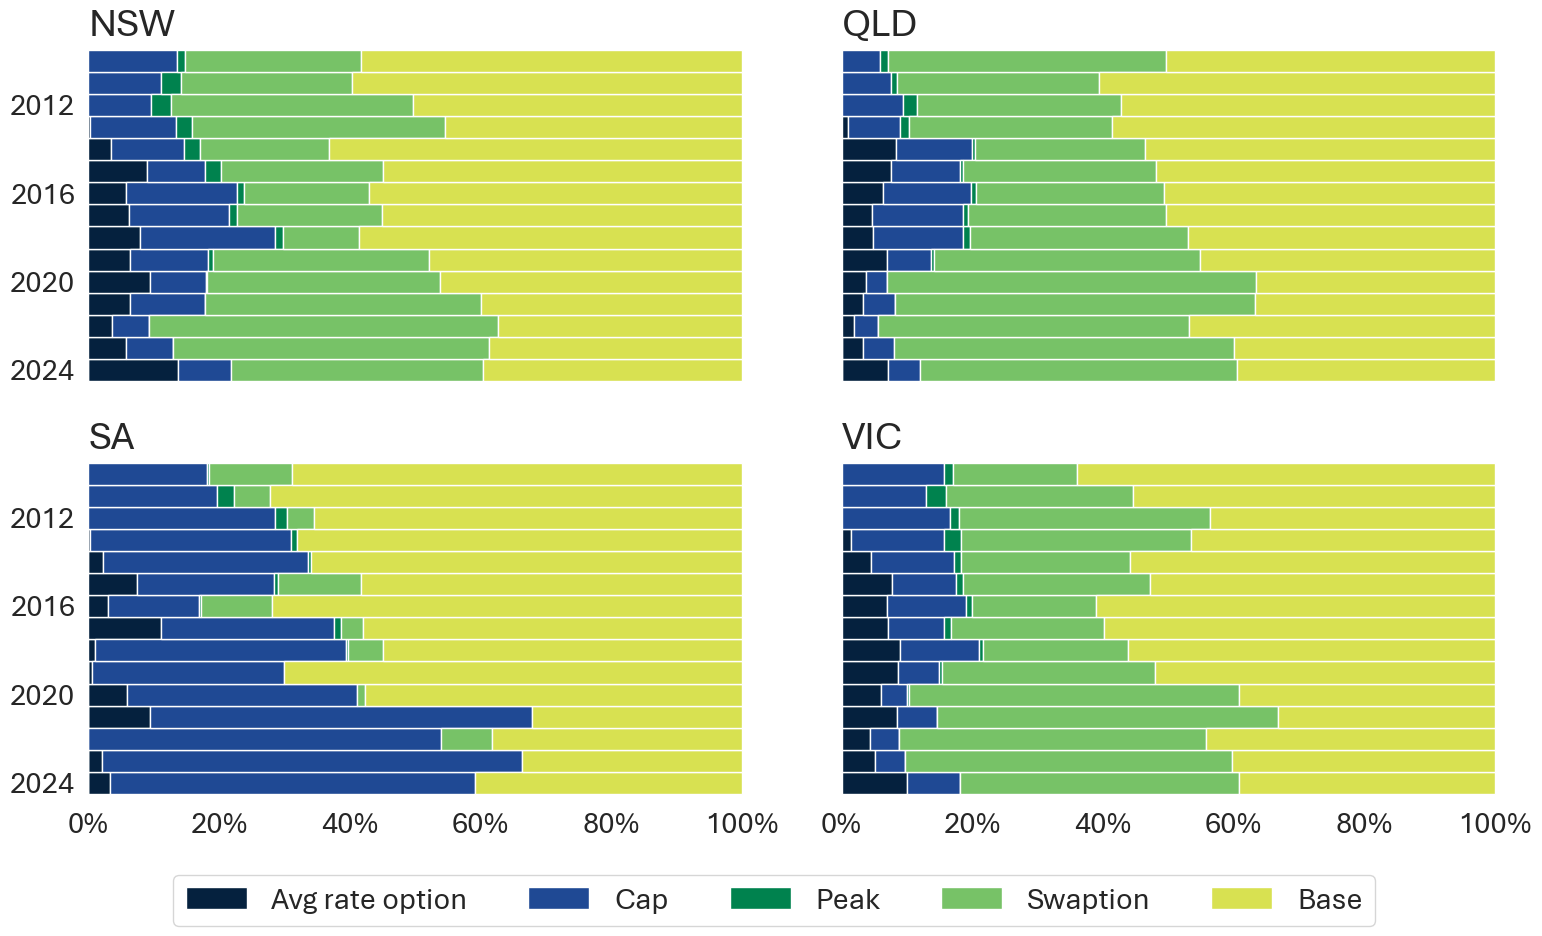

In [54]:
# Plot chart
fig, ax = plt.subplots(
    2, 2,
    figsize=(16, 9),
    tight_layout=True,
    sharex=True,
    sharey=True)
regions = ["NSW", "QLD", "SA", "VIC"]
for i, region in enumerate(regions):
    axis = ax[i // 2, i % 2]
    chart_data = asx_data[
        asx_data["Region"] == region].copy()
    chart_data["Year"] = chart_data["Quarter"].dt.year
    chart_data = chart_data.pivot_table(
        index="Year",
        columns="Contract",
        values="Volume",
        aggfunc="sum").loc[2010:2024]
    chart_data["Base"] = chart_data["Base monthly"] + chart_data["Base quarterly"]
    chart_data.drop(columns=["Base monthly", "Base quarterly"], inplace=True)
    chart_data = chart_data.div(chart_data.sum(axis=1), axis=0)
    chart_data.sort_index(ascending=False, inplace=True)
    chart_data.plot(
        kind="barh",
        stacked=True,
        width=1,
        ax=axis,
        color=["C0", "C1", "C2", "C3", "C4"])
    for frame in ["top", "right", "bottom", "left"]:
        axis.spines[frame].set_visible(False)
    axis.set_ylabel(None)
    axis.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(1))
    axis.get_legend().set_title(None)
    handles, labels = axis.get_legend_handles_labels()
    axis.get_legend().remove()
    axis.set_title(region, fontsize="large", loc="left")
    axis.set_yticks(axis.get_yticks()[::4])
fig.legend(
    handles=handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.075),
    ncols=5)
plt.show()

Avg rate option


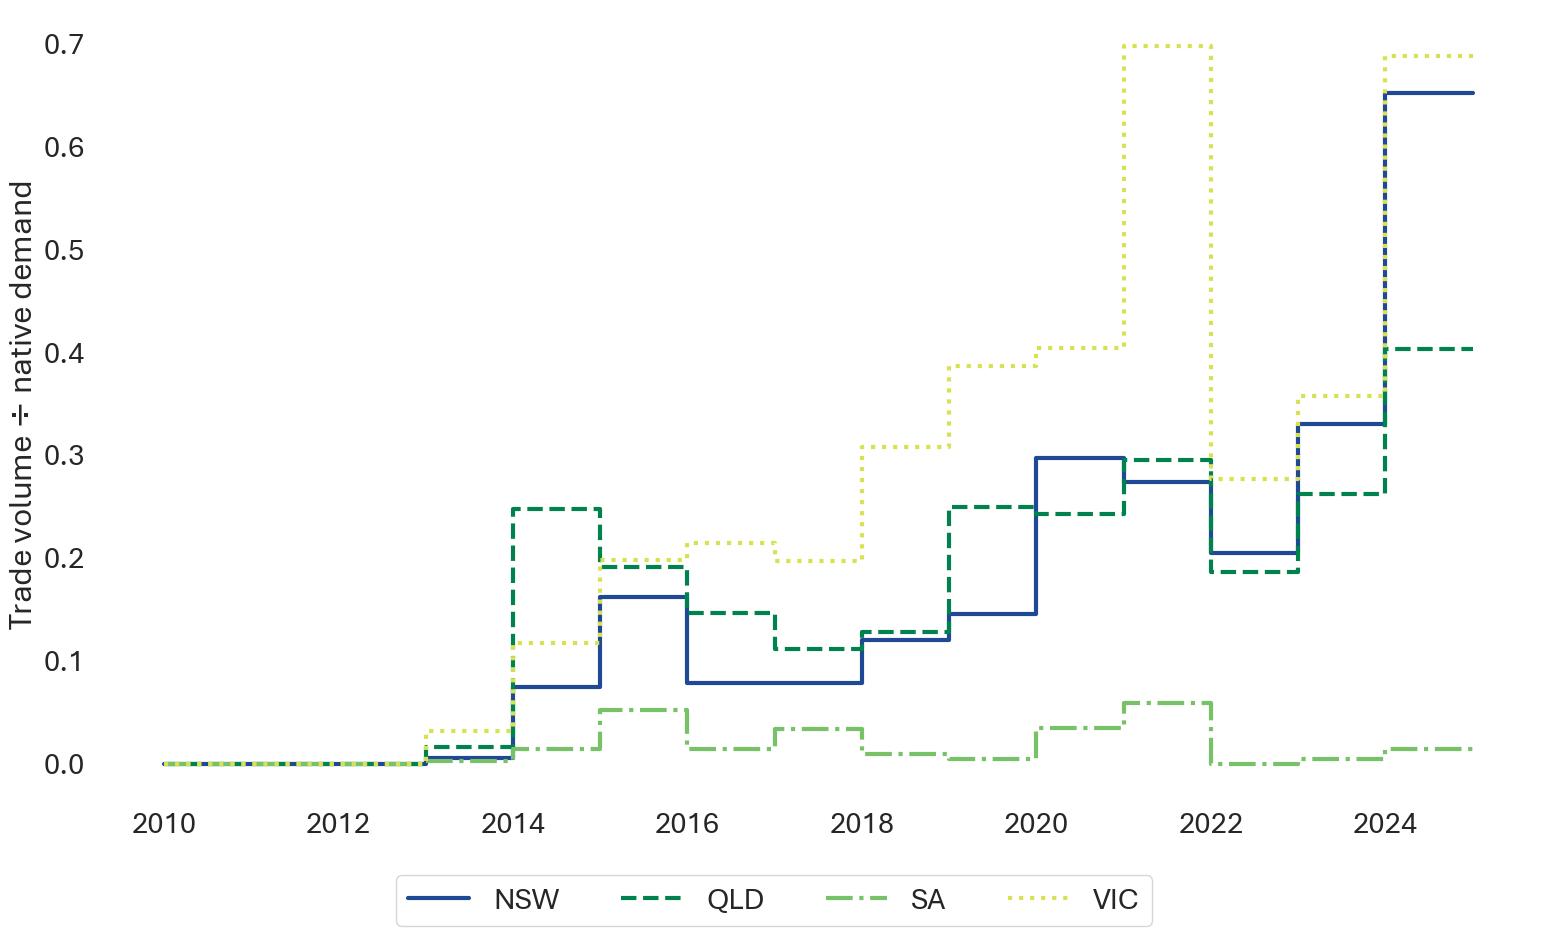

Base monthly


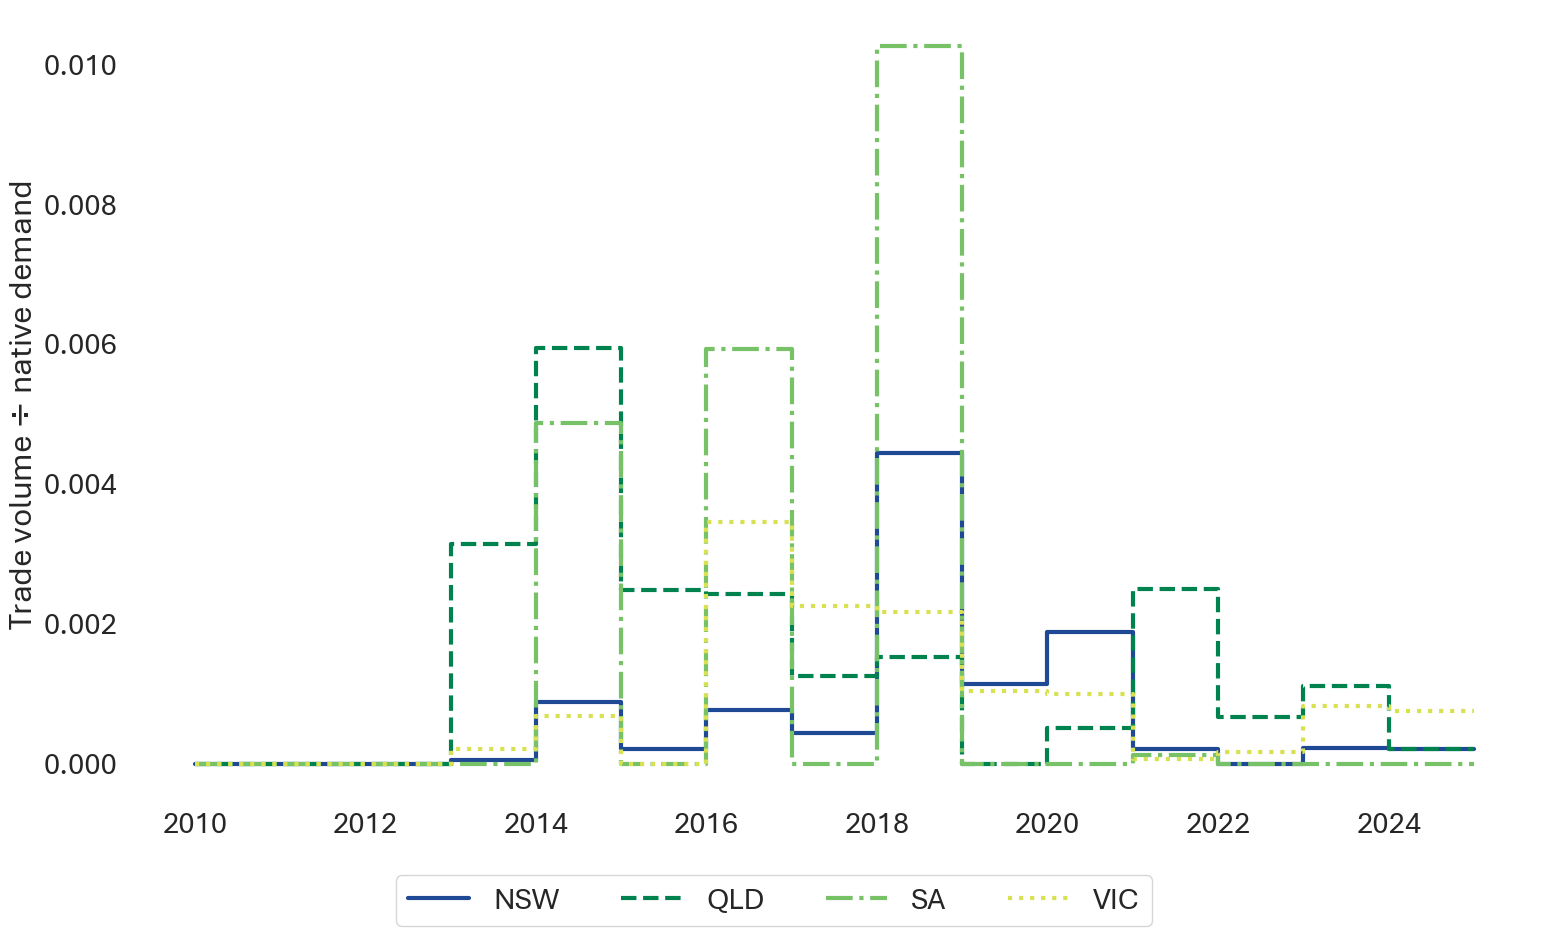

Base quarterly


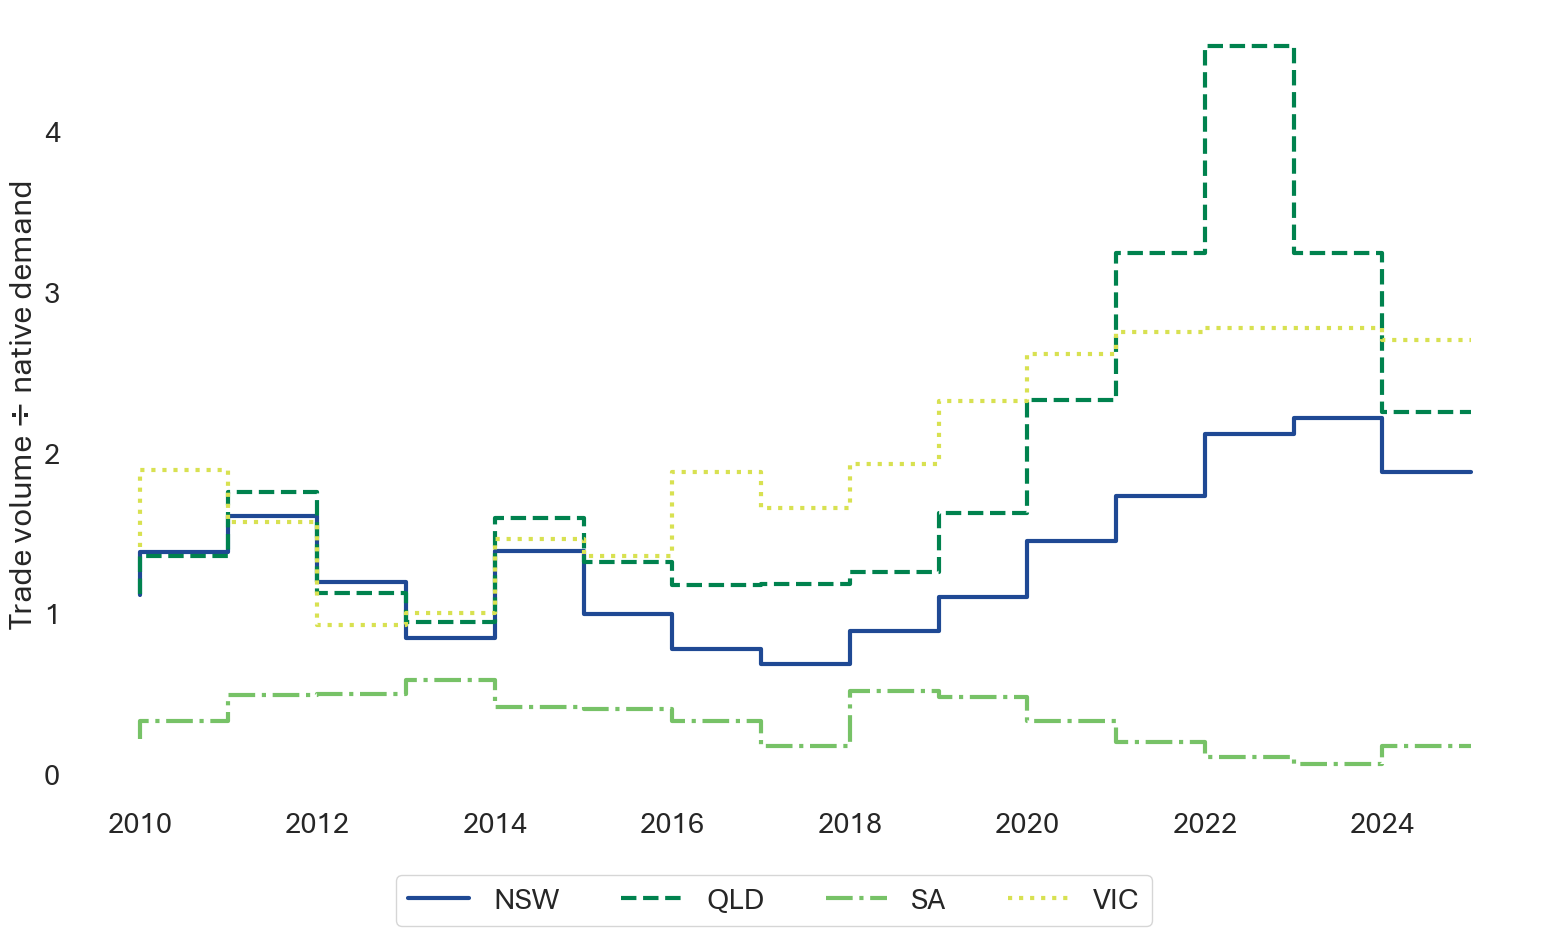

Cap


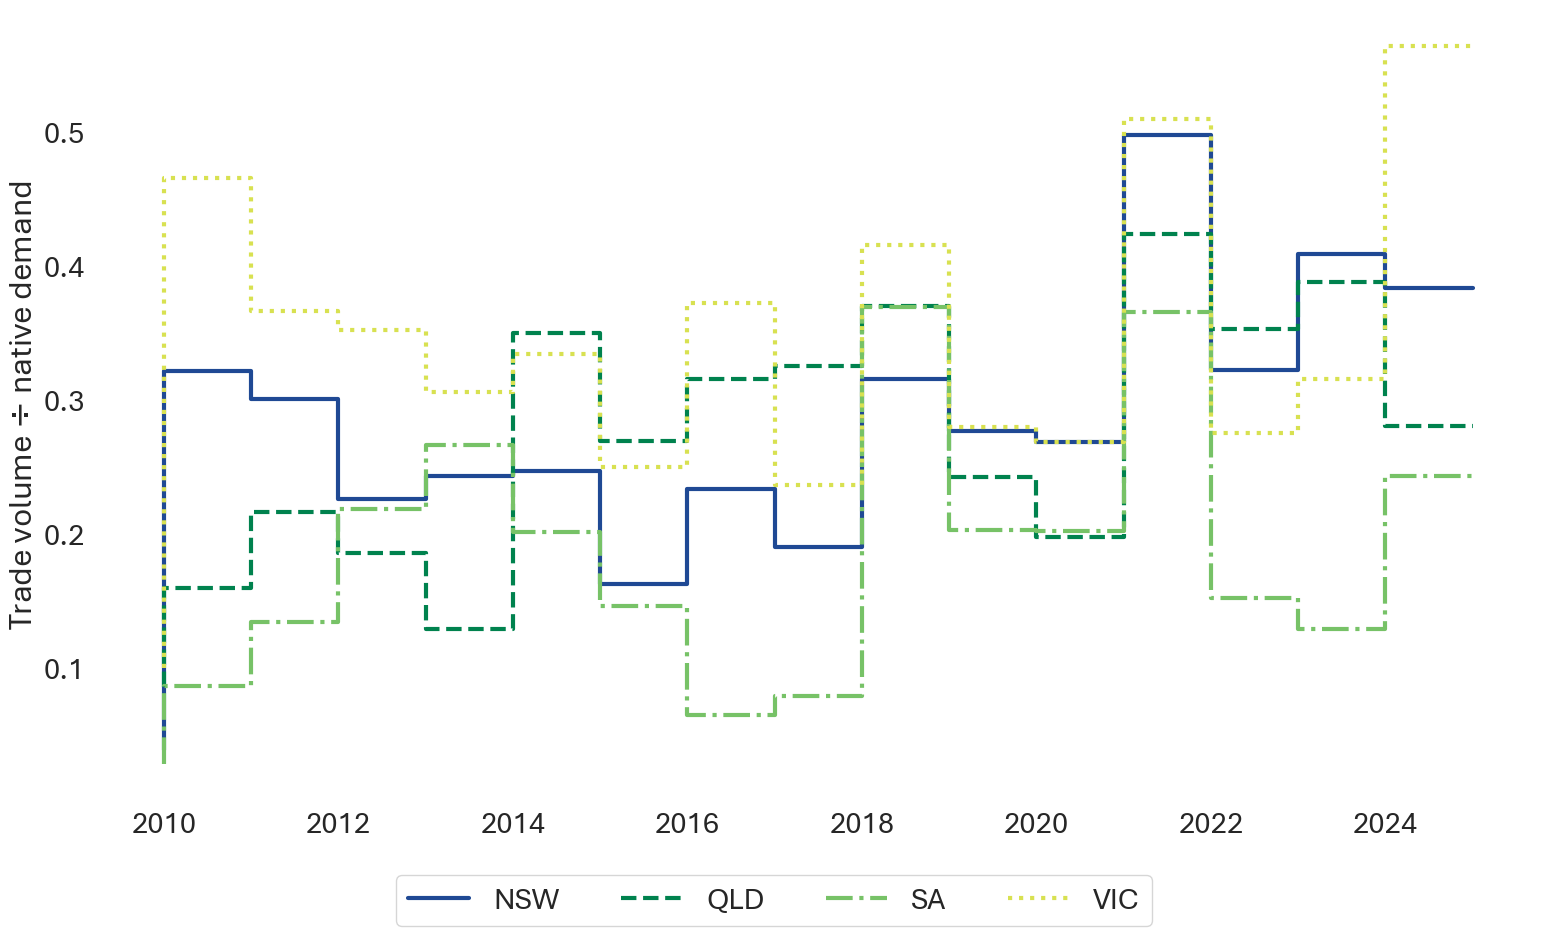

Peak


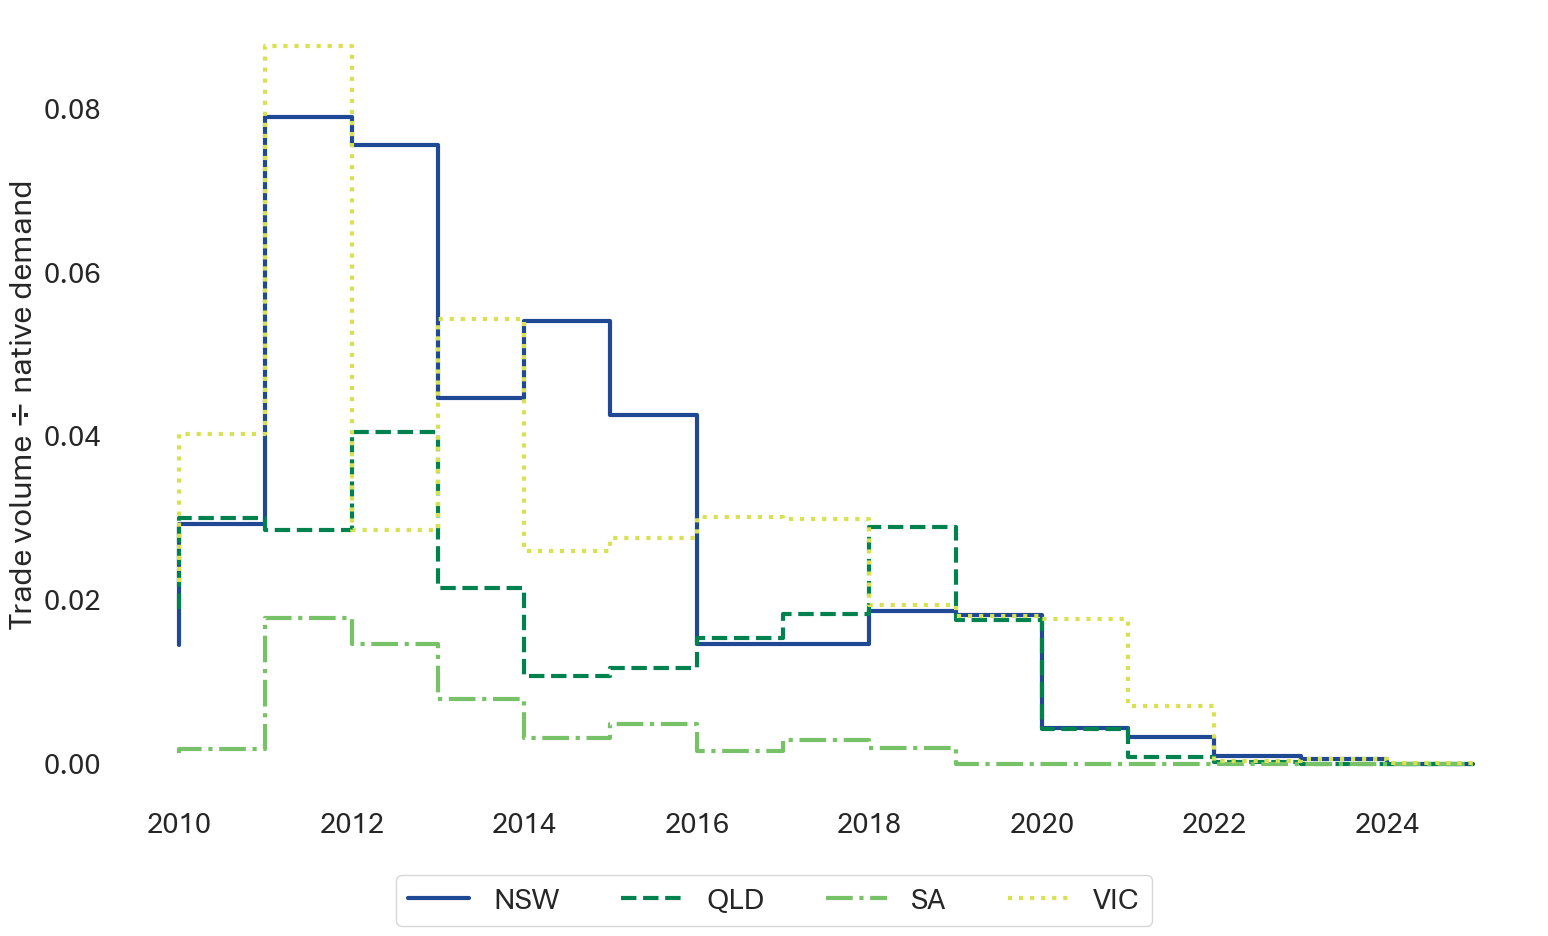

Swaption


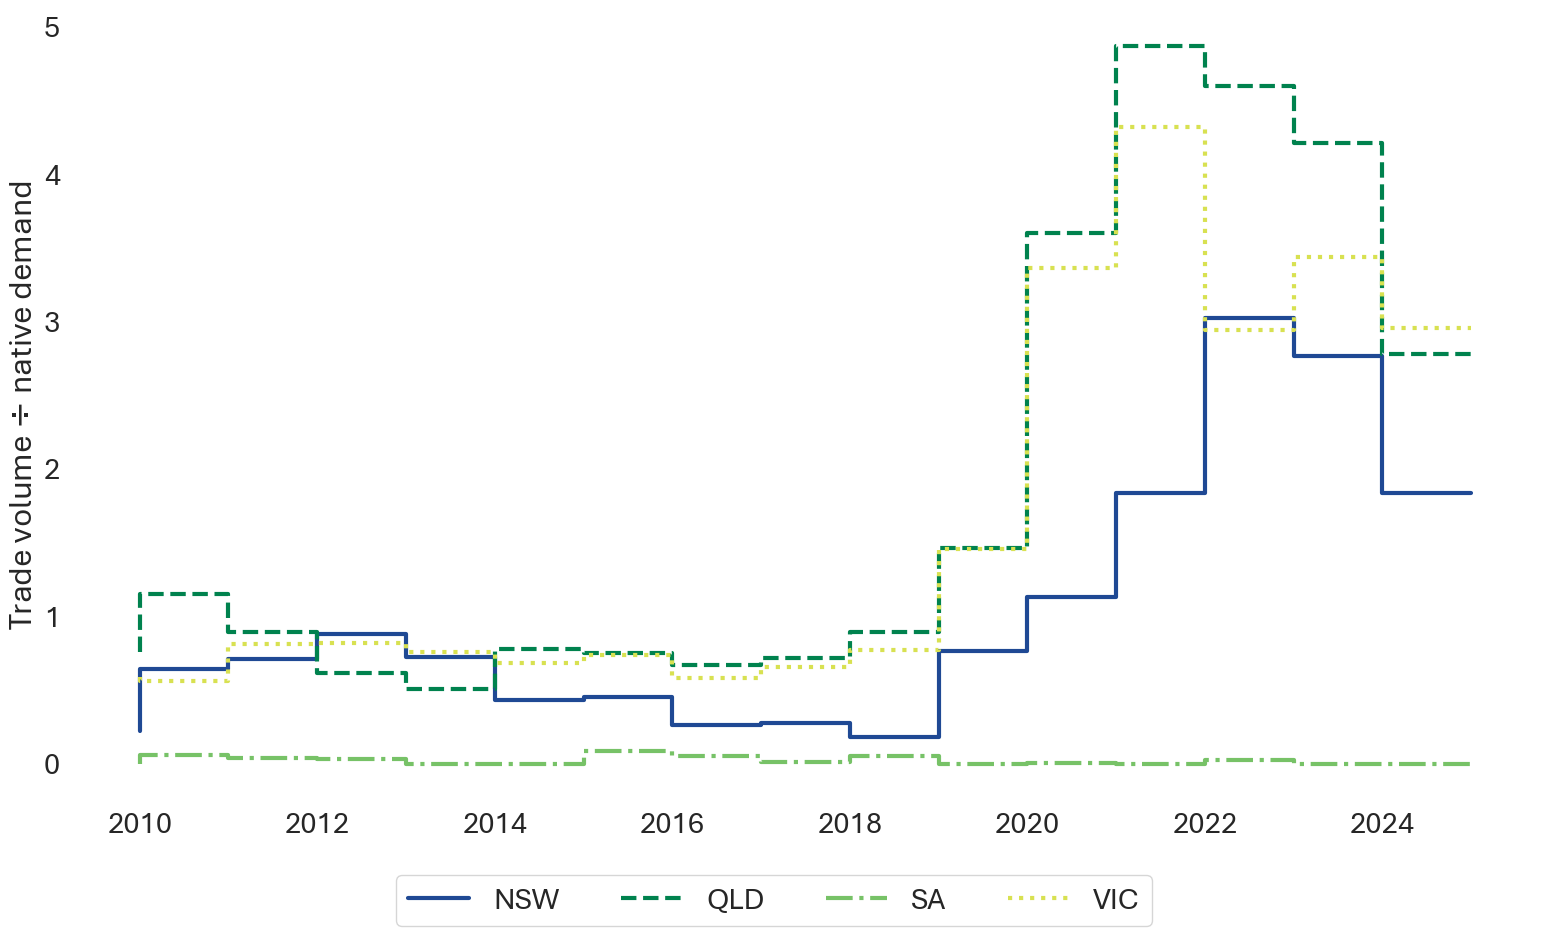

In [55]:
for contract in asx_data["Contract"].unique():
    # Plot chart
    fig, ax = plt.subplots(
        figsize=(16, 9),
        tight_layout=True)
    regions = ["NSW", "QLD", "SA", "VIC"]
    chart_data = asx_data[
        asx_data["Contract"] == contract].copy().pivot(
            index="Quarter",
            columns="Region",
            values="Volume").loc["2009-01-01":"2024-12-31"]
    chart_data = (chart_data[regions].resample("YE").sum() / demand_data[regions].resample("YE").sum())
    for i, region in enumerate(chart_data.columns):
        ax.step(
            x=chart_data.index,
            y=chart_data[region],
            linewidth=3,
            linestyle=["-", "--", "-.", ":"][i],
            color=f"C{i + 1}",
            label=region)
    for frame in ["top", "right", "bottom", "left"]:
        ax.spines[frame].set_visible(False)
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel(None)
    plt.ylabel(r"Trade volume $\div$ native demand")
    fig.legend(
        handles=handles,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.075),
        ncols=4)
    print(contract)    
    plt.show()

### Estimated benefits of IPRR over time

In [56]:
asx_data.Contract.value_counts()

Contract
Avg rate option    328
Base monthly       328
Base quarterly     328
Cap                328
Peak               328
Swaption           328
Name: count, dtype: int64

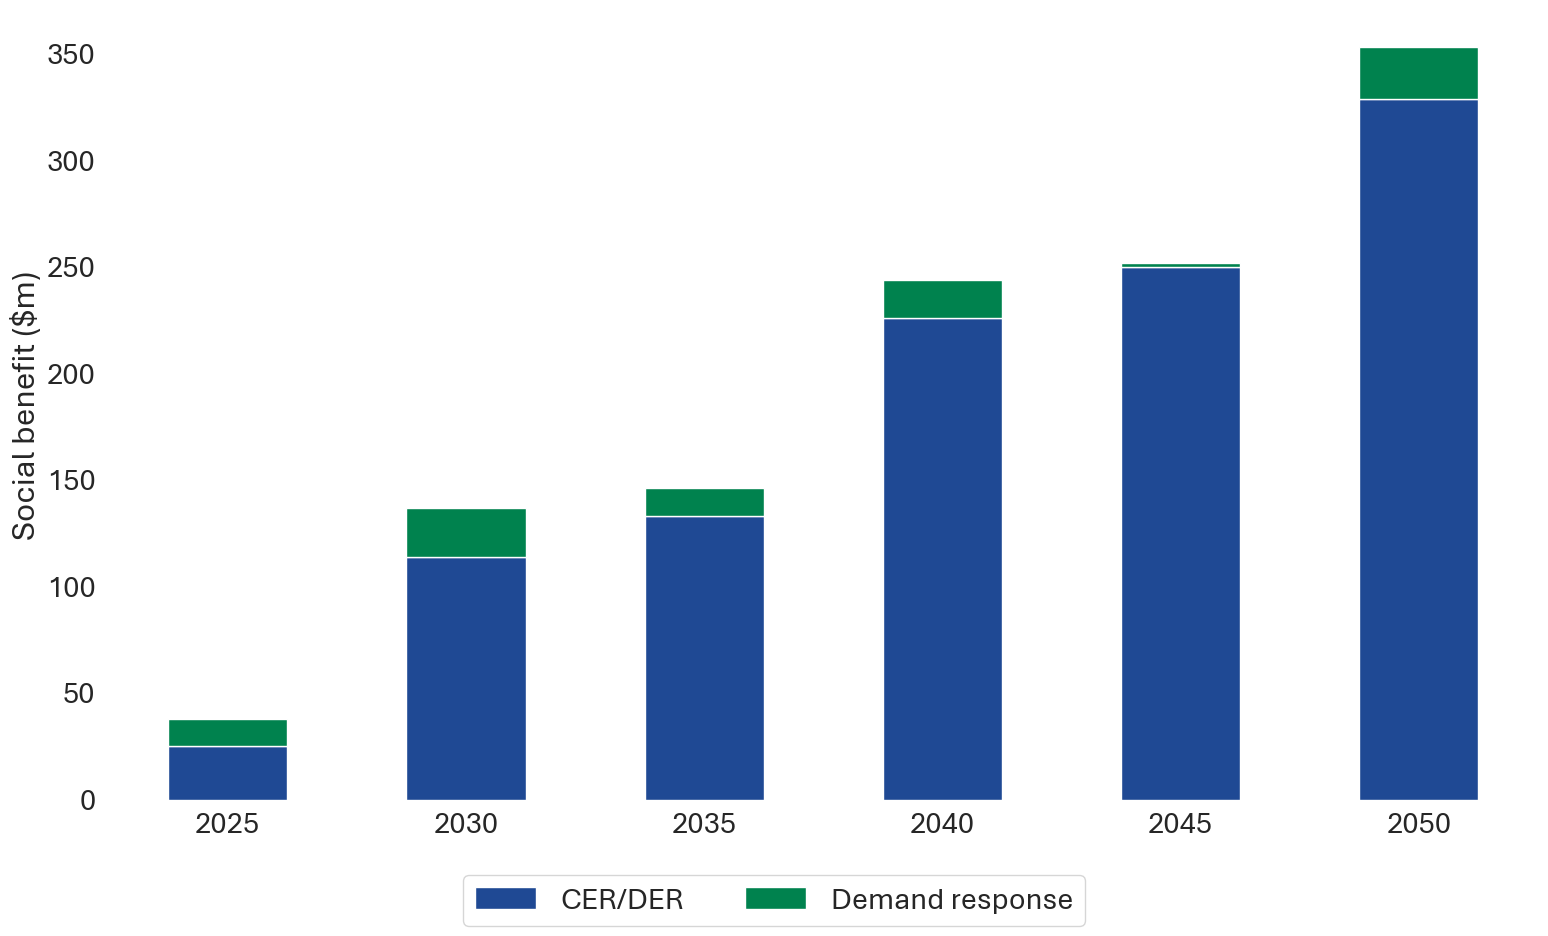

In [57]:
# Replicate data
chart_data = pd.DataFrame(
    data={
        "Year": range(2025, 2055, 5),
        "CER/DER": [25, 114, 133, 226, 250, 329],
        "Demand response": [13, 23, 13, 18, 2, 24]})
chart_data.set_index("Year", inplace=True)

# Plot chart
fig, ax = plt.subplots(
    figsize=(16, 9),
    tight_layout=True)
chart_data.plot(
    kind="bar",
    stacked=True,
    color=palette,
    ax=ax)
plt.ylabel("Social benefit ($m)")
plt.xlabel(None)
plt.xticks(rotation=0)
for frame in ["top", "left", "bottom", "right"]:
    ax.spines[frame].set_visible(False)
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.075), ncol=2)
plt.show()
chart_data.to_clipboard()

### Estimated benefits of reducing RERT costs

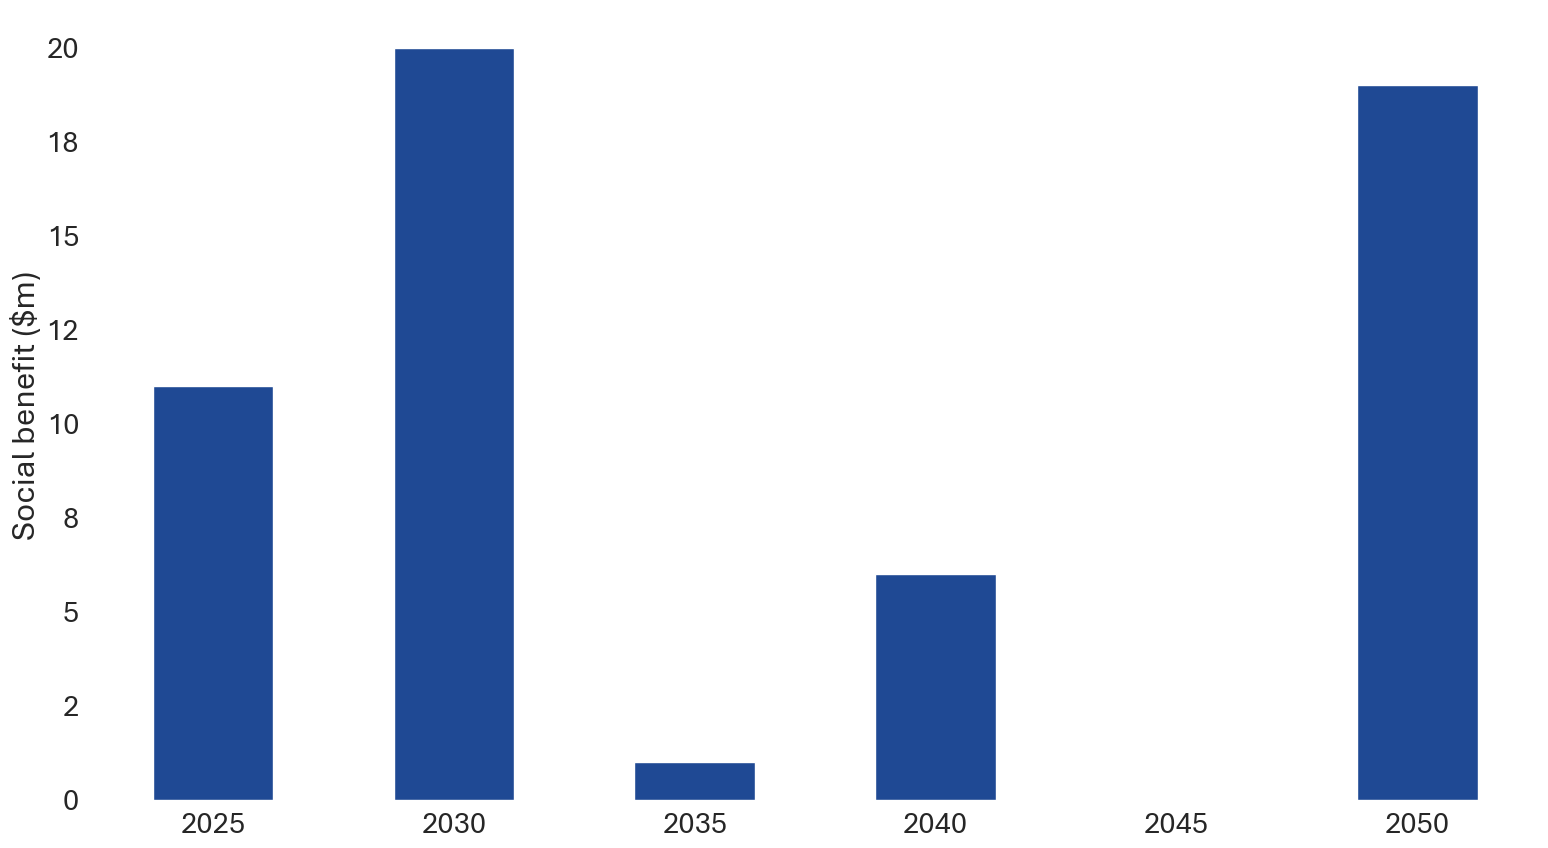

In [58]:
# Replicate data
chart_data = pd.DataFrame(
    data={
        "Year": range(2025, 2055, 5),
        "Benefits": [11, 20, 1, 6, 0, 19]})
chart_data.set_index("Year", inplace=True)

# Plot chart
fig, ax = plt.subplots(
    figsize=(16, 9),
    tight_layout=True)
chart_data.plot(
    kind="bar",
    stacked=True,
    color=sns.color_palette()[1:],
    ax=ax)
ax.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
plt.ylabel("Social benefit ($m)")
plt.xlabel(None)
plt.xticks(rotation=0)
ax.get_legend().remove()
for frame in ["top", "left", "bottom", "right"]:
    ax.spines[frame].set_visible(False)
chart_data.to_clipboard()

### Reliability risk is shifting from summer to winter

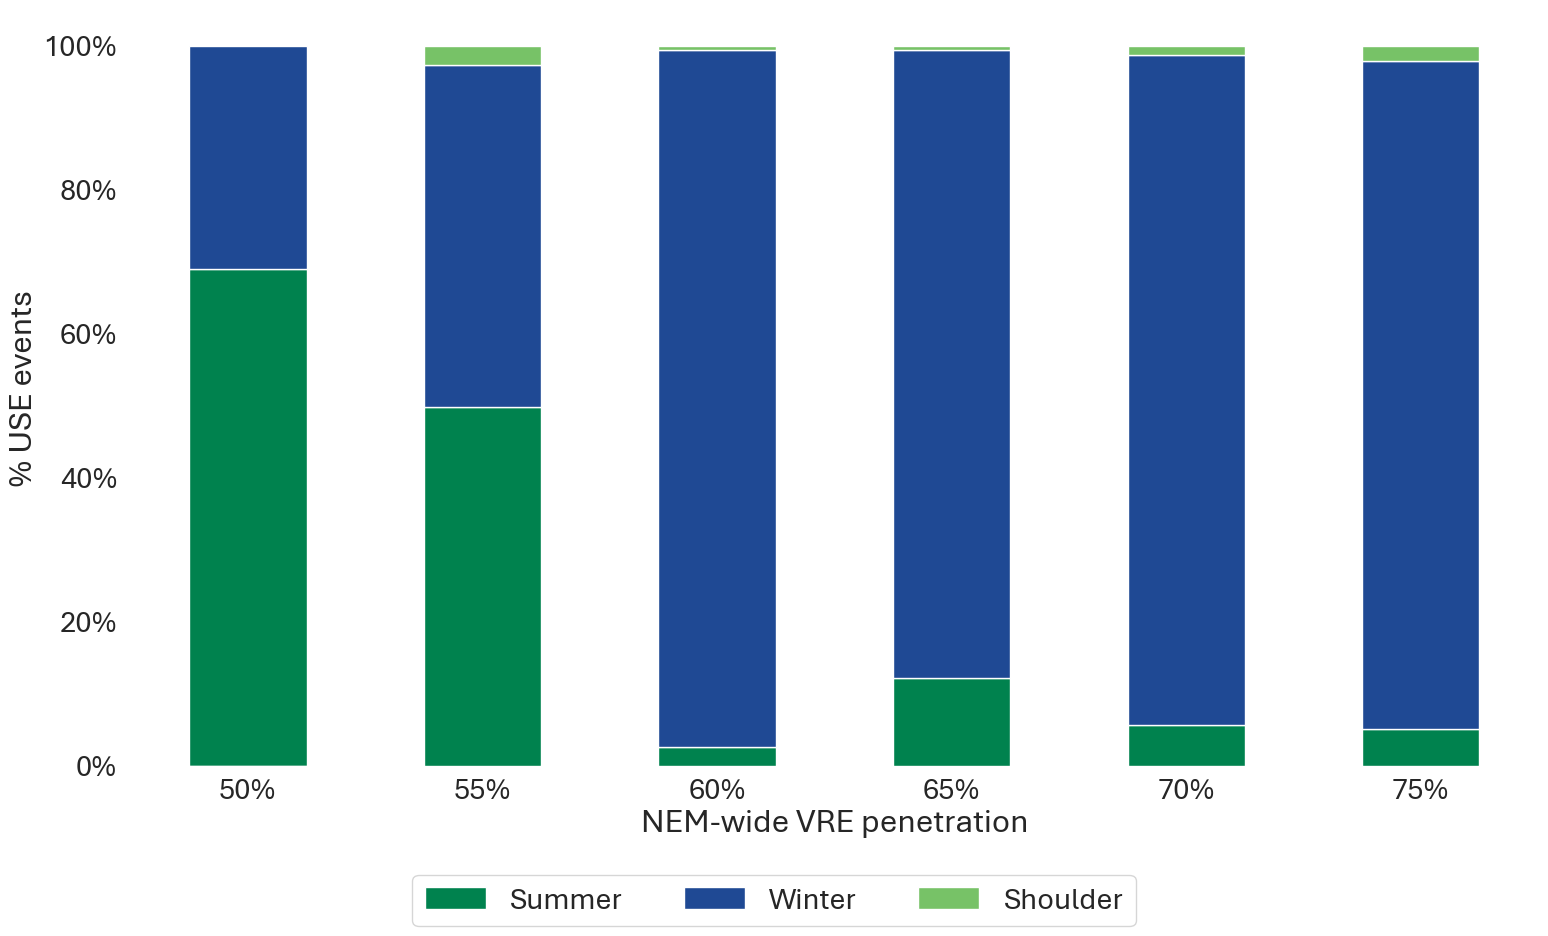

In [59]:
# Replicate data
chart_data = pd.DataFrame(
    data={
        "VRE penetration": [.5, .55, .6, .65, .7, .75],
        "Summer": [.69043, .49898, .02648, .1222, .05703, .05092],
        "Winter": [.3096, .4745, .9674, .8717, .9308, .9287],
        "Shoulder": [.0, .026477, .00611, .00611, .01222, .020367]})
chart_data.set_index("VRE penetration", inplace=True)
chart_data.index = chart_data.index.map(lambda i: f"{i:.0%}")
# Plot chart
fig, ax = plt.subplots(
    figsize=(16, 9),
    tight_layout=True)
chart_data.plot(
    kind="bar",
    stacked=True,
    color=["C2", "C1", "C3"],
    ax=ax)
ax.yaxis.set_major_formatter(lambda x, p: f"{x:,.0%}")
# ax.xaxis.set_major_formatter(lambda x, p: f"{x:,.0%}")
plt.xticks(rotation=0)
plt.ylabel("% USE events")
plt.xlabel("NEM-wide VRE penetration")
plt.xticks(rotation=0)
for frame in ["top", "left", "bottom", "right"]:
    ax.spines[frame].set_visible(False)
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.075), ncol=3)
plt.show()
chart_data.to_clipboard()

### Number of bids by NEM participants per day, July 2016 to June 2025

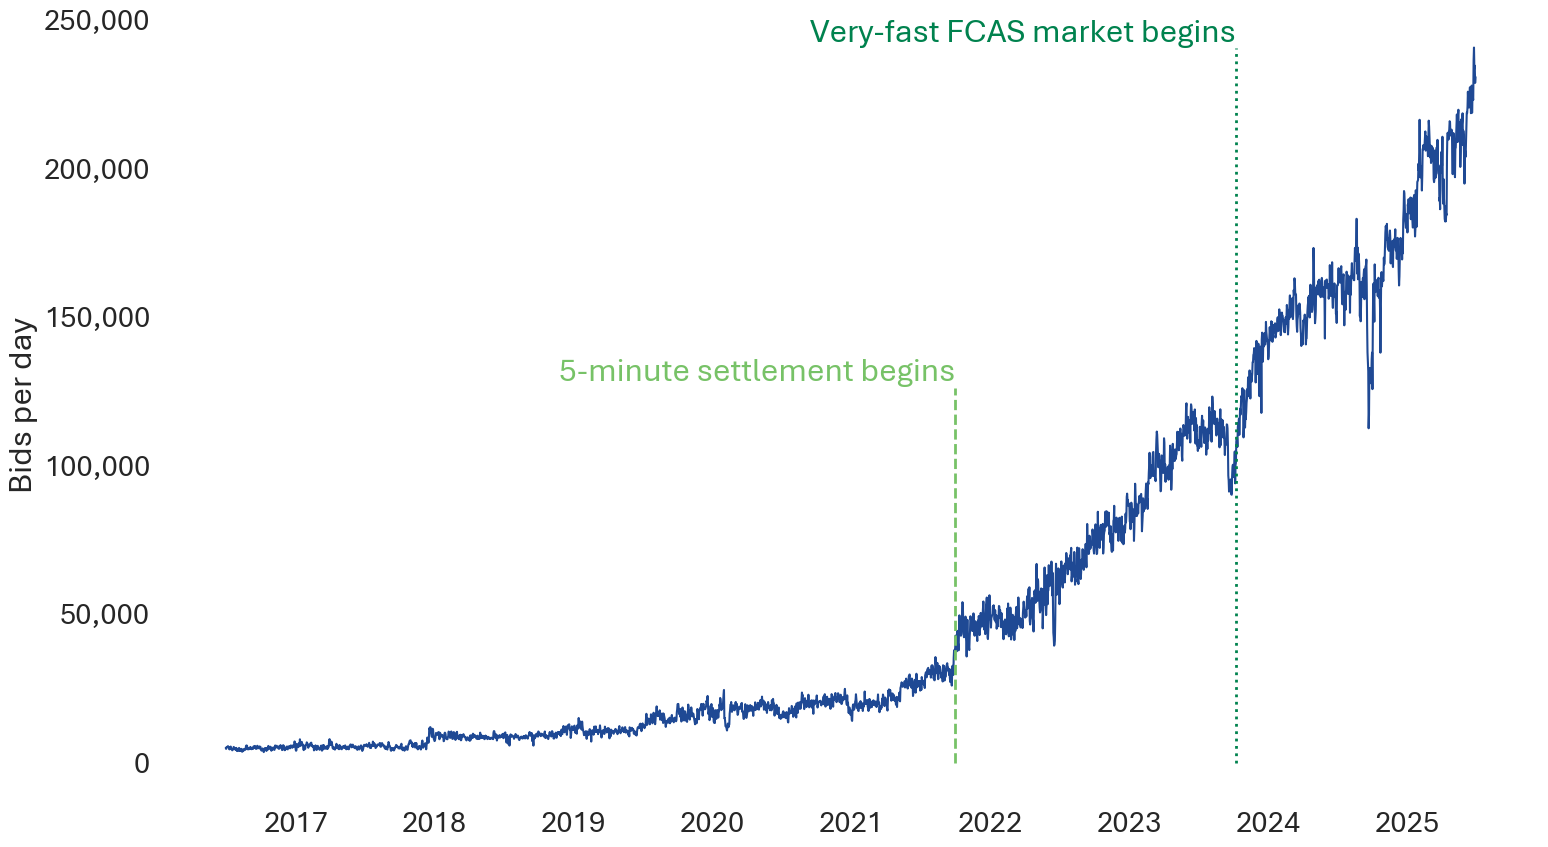

In [60]:
# Collect bid data
bid_data = get_mms_data(
    "number_of_bids",
    arguments={
        "start_date": "2016-07-01",
        "end_date": "2025-06-30"})
# Conversions
bid_data["Date"] = pd.to_datetime(bid_data["Date"])

# Plot chart
fig, ax = plt.subplots(
    figsize=(16, 9),
    tight_layout=True)
ax.plot(
    bid_data["Date"],
    bid_data["Bids per day"],
    color="C1")
ax.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
plt.ylabel("Bids per day")
# plt.xlabel("NEM-wide VRE penetration")
# plt.xticks(rotation=0)
for frame in ["top", "left", "bottom", "right"]:
    ax.spines[frame].set_visible(False)
ax.vlines(
    x=pd.to_datetime("2021-10-01"),
    ymin=0, ymax=ax.get_ylim()[1] / 2,
    linewidth=2,
    linestyle="--",
    color="C3")
plt.text(
    x=pd.to_datetime("2021-10-01"),
    y=ax.get_ylim()[1] / 2,
    s="5-minute settlement begins",
    color="C3",
    ha="right", va="bottom")
ax.vlines(
    x=pd.to_datetime("2023-10-09"),
    ymin=0, ymax=bid_data["Bids per day"].max(),
    linewidth=2,
    linestyle=":",
    color="C2")
plt.text(
    x=pd.to_datetime("2023-10-09"),
    y=bid_data["Bids per day"].max(),
    s="Very-fast FCAS market begins",
    color="C2",
    ha="right", va="bottom")
plt.show()
bid_data.to_clipboard()